In [86]:
import pandas as pd
import numpy as np
import warnings 
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder,StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression,Ridge,Lasso
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import ExtraTreesRegressor
import time
from sklearn.ensemble import GradientBoostingRegressor,VotingRegressor, RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor, Pool, cv
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from tqdm import tqdm

In [148]:
train = pd.read_csv("train2.csv").drop(['사망자수','중상자수','경상자수','부상자수'],axis=1)
test = pd.read_csv("test(통합본).csv")

In [149]:
def road(types):
    return types.split('-')[0].strip()

In [150]:
def gu(address):
    return address.split()[0]
def dong(address):
    return address.split()[1]

In [151]:
for df in [train,test]:
    df['구'] = df['주소'].apply(gu)
    df['동'] = df['주소'].apply(dong)
    df.drop('주소',axis=1,inplace=True)
    df['도로타입'] = df['도로형태'].apply(road)
    df.drop('도로형태',axis=1,inplace=True)

In [152]:
test.columns

Index(['요일', '기상상태', '노면상태', '사고유형', '연휴', '년도', '월', '일', '시간', '설치장소',
       '설치개수', 'CCTV설치대수', '급지구분_1', '급지구분_2', '급지구분_3', '구', '동', '도로타입'],
      dtype='object')

In [153]:
train.columns

Index(['요일', '기상상태', '노면상태', '사고유형', '연휴', '년도', '월', '일', '시간', 'ECLO',
       '설치장소', '설치개수', 'CCTV설치대수', '급지구분_1', '급지구분_2', '급지구분_3', '구', '동',
       '도로타입'],
      dtype='object')

In [154]:
train = train[['요일', '기상상태', '도로타입', '노면상태', '사고유형', '구', '동', '연휴', '년도', '월', '일', '시간',
       '설치장소', '설치개수', 'CCTV설치대수', '급지구분_1', '급지구분_2', '급지구분_3', 'ECLO']]
test = test[['요일', '기상상태', '도로타입', '노면상태', '사고유형', '구', '동', '연휴', '년도', '월', '일', '시간',
       '설치장소', '설치개수', 'CCTV설치대수', '급지구분_1', '급지구분_2', '급지구분_3']]

<AxesSubplot:xlabel='ECLO', ylabel='Density'>

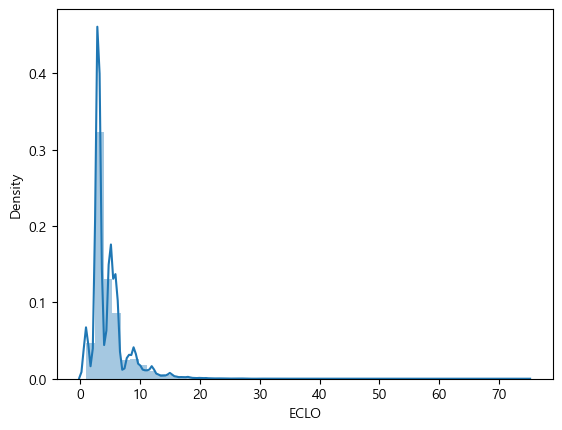

In [155]:
sns.distplot(train['ECLO'])

<AxesSubplot:xlabel='ECLO', ylabel='Density'>

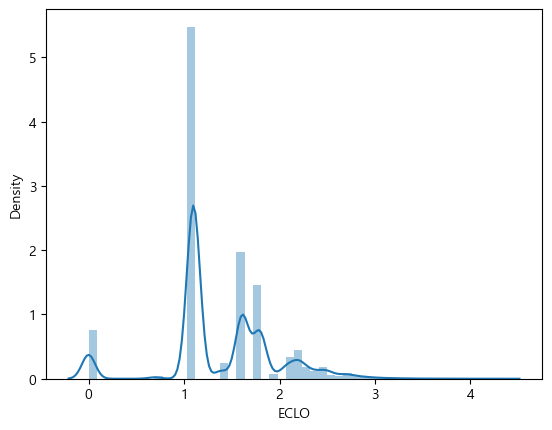

In [156]:
sns.distplot(np.log1p(train['ECLO']))

In [157]:
np.log1p(train['ECLO']).skew(),np.log1p(train['ECLO']).kurt()

(0.46224288437379557, 0.9717824269749609)

In [158]:
np.log(train['ECLO']).skew(),np.log(train['ECLO']).kurt()

(-0.05947172323251955, 0.9979248812081076)

In [159]:
test_for_test = test.copy()
train_for_test = train.copy()

In [160]:
categorical_features = list(train.dtypes[train.dtypes == "object"].index)
display(categorical_features)

for i in categorical_features:
    le = LabelEncoder()
    le=le.fit(train[i]) 
    train[i]=le.transform(train[i])
    
    for case in np.unique(test[i]):
        if case not in le.classes_: 
            le.classes_ = np.append(le.classes_, case) 
    test[i]=le.transform(test[i])

['요일', '기상상태', '도로타입', '노면상태', '사고유형', '구', '동']

In [161]:
X = train.drop('ECLO',axis=1).values
y = train['ECLO'].values
y = np.log1p(y)

In [166]:
# for i in range(0,7):
#     X[:,i] = LabelEncoder().fit_transform(X[:,i])
st = StandardScaler()
X_standard = st.fit_transform(X)
mm = MinMaxScaler()
X_minmax = mm.fit_transform(X)

In [167]:
# x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.2)
x_train,x_test,y_train,y_test = train_test_split(X_standard,y,test_size=0.2)
#x_train,x_test,y_train,y_test = train_test_split(X_minmax,y,test_size=0.2)

In [165]:
# RMSLE
def evaluate_regr(y,pred):
    # MAE
    mae = mean_absolute_error(y,pred)
    
    # RMSE
    rmse = np.sqrt(mean_squared_error(y,pred))
    
    # RMSLE
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    msle = np.mean((log_y - log_pred) ** 2)
    rmsle = np.sqrt(msle)    
    
    print(f'MAE: {mae:.3f}, RMSE: {rmse:.3f}, RMSLE: {rmsle:.3f}')
    
def get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=False):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    if is_expm1:
        y_test = np.expm1(y_test)
        pred = np.expm1(pred)
    
    print('###',model.__class__.__name__,'###')
    evaluate_regr(y_test, pred)
    
lr_reg = LinearRegression()
ridge_reg = Ridge(alpha=10)
lasso_reg = Lasso(alpha=0.01)

# 성능 평가
models = [lr_reg, ridge_reg, lasso_reg]

for model in models:
    get_model_predict(model, x_train, x_test, y_train, y_test, is_expm1=True)
    
# 회귀 트리 모델
rf_reg = RandomForestRegressor()
gb_reg = GradientBoostingRegressor()
xgb_reg = XGBRegressor()
lgbm_reg = LGBMRegressor()

# 성능 평가
models = [rf_reg, gb_reg, xgb_reg, lgbm_reg]

for model in models:
    get_model_predict(model, x_train, x_test, y_train, y_test, is_expm1=True)
    
def rmsle(predicted_values, actual_values):
    predicted_values = np.array(predicted_values)
    actual_values = np.array(actual_values)

    log_predict = np.log(predicted_values + 1)
    log_actual = np.log(actual_values + 1)

    difference = log_predict - log_actual
    difference = np.square(difference)
    mean_difference = difference.mean()
    score = np.sqrt(mean_difference)

    return score

rmsle_scorer = make_scorer(rmsle)

validation_model = ExtraTreesRegressor(n_jobs = -1, random_state = 42)
cv = KFold(5, shuffle=True, random_state=42)
scores = cross_val_score(validation_model, x_train, y_train, cv=cv, scoring=rmsle_scorer)

print("교차 검증 점수: {}". format(scores))
print("교차 검증 평균 점수: {:.2f}".format(scores.mean()))

### LinearRegression ###
MAE: 2.083, RMSE: 3.241, RMSLE: 0.451
### Ridge ###
MAE: 2.083, RMSE: 3.241, RMSLE: 0.451
### Lasso ###
MAE: 2.091, RMSE: 3.247, RMSLE: 0.452
### RandomForestRegressor ###
MAE: 2.117, RMSE: 3.266, RMSLE: 0.463
### GradientBoostingRegressor ###
MAE: 2.061, RMSE: 3.213, RMSLE: 0.446
### XGBRegressor ###
MAE: 2.094, RMSE: 3.249, RMSLE: 0.459
### LGBMRegressor ###
MAE: 2.065, RMSE: 3.216, RMSLE: 0.448
교차 검증 점수: [0.18502957 0.18189651 0.1797482  0.18302346 0.18214761]
교차 검증 평균 점수: 0.18


In [168]:
test_standard = st.transform(test.iloc[:,:])
#test_standard = mm.fit_transform(test.iloc[:,:])
test_standard

array([[ 1.00944067, -0.25097249, -1.10208402, ..., -0.42749185,
        -0.51618846, -0.62004916],
       [ 1.00944067, -0.25097249,  0.90908603, ..., -0.42749185,
        -0.51618846, -0.1505854 ],
       [ 1.00944067, -0.25097249, -1.10208402, ..., -0.42749185,
        -0.51618846, -0.62004916],
       ...,
       [ 1.00944067, -0.25097249,  0.90908603, ..., -0.42749185,
        -0.51618846, -0.62004916],
       [ 1.00944067, -0.25097249, -1.10208402, ..., -0.42749185,
        -0.51618846, -0.62004916],
       [ 1.00944067, -0.25097249, -1.10208402, ..., -0.42749185,
        -0.51618846, -0.62004916]])

## RandomForestRegressor

In [106]:
start_time = time.time()
rf = RandomForestRegressor(random_state=42).fit(x_train,y_train)
rf_base_pred = rf.predict(x_test)
print('RandomForest RMSLE: {0:.4f}'.format(rmsle(y_test,rf_base_pred)))
evaluate_regr(y_test,rf_base_pred)
params = {
    'n_estimators':[100,200,300],
    'max_depth' : [3,10,12,15], 
    'min_samples_leaf' : [5,8,10],
    'min_samples_split' : [5,8,10]
}
rf_grid_cv = GridSearchCV(rf,param_grid = params, cv=3,n_jobs=-1,scoring=rmsle_scorer).fit(x_train,y_train)

print('최적 하이퍼 파라미터:\n', rf_grid_cv.best_params_)
rf_praram = rf_grid_cv.best_params_
rf_pred = rf_grid_cv.best_estimator_.predict(x_test)
print('rf RMSLE: {0:.4f}'.format(rmsle(y_test,rf_pred)))
print('수행속도 : {0:.1f}초'.format(time.time()-start_time))

RandomForest RMSLE: 0.1770
MAE: 0.361, RMSE: 0.461, RMSLE: 0.177
최적 하이퍼 파라미터:
 {'max_depth': 15, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 100}
rf RMSLE: 0.1722
수행속도 : 669.2초


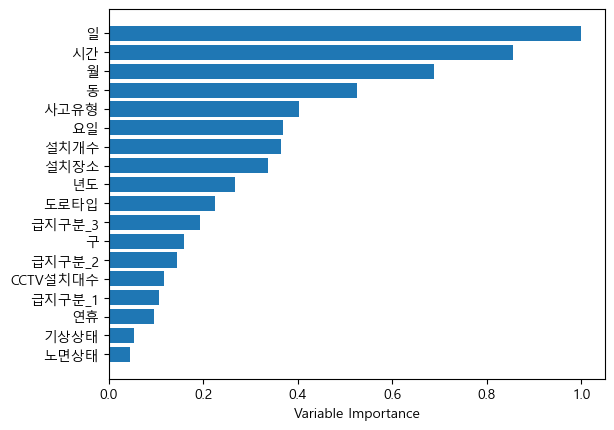

In [107]:
rf_imp= RandomForestRegressor(**rf_grid_cv.best_params_).fit(x_train,y_train)
# import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Malgun Gothic'
featureImportance = rf_imp.feature_importances_
featureImportance = featureImportance/featureImportance.max()
sorted_idx = np.argsort(featureImportance)
barPos = np.arange(sorted_idx.shape[0])+.5
plt.barh(barPos, featureImportance[sorted_idx], align='center')
plt.yticks(barPos,  np.array(train.columns[:-1])[sorted_idx])
plt.xlabel('Variable Importance')
plt.show()

In [169]:
categorical_features = list(train_for_test.dtypes[train_for_test.dtypes == "object"].index)
display(categorical_features)

for i in categorical_features:
    le = LabelEncoder()
    le=le.fit(train_for_test[i]) 
    train_for_test[i]=le.transform(train_for_test[i])
    
    for case in np.unique(test_for_test[i]):
        if case not in le.classes_: 
            le.classes_ = np.append(le.classes_, case) 
    test_for_test[i]=le.transform(test_for_test[i])

['요일', '기상상태', '도로타입', '노면상태', '사고유형', '구', '동']

In [170]:
# X = train_for_test.drop(['기상상태','노면상태','CCTV설치대수','연휴','ECLO'],axis=1).values
# test_for_test = test_for_test.drop(['기상상태','노면상태','CCTV설치대수','연휴'],axis=1)

X = train_for_test.drop(['기상상태','노면상태','ECLO'],axis=1).values
test_for_test = test_for_test.drop(['기상상태','노면상태'],axis=1)

In [171]:
st = StandardScaler()
X_standard = st.fit_transform(X)
#mm = MinMaxScaler()
# X_minmax = mm.fit_transform(X)

# # x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.2)
x_train,x_test,y_train,y_test = train_test_split(X_standard,y,test_size=0.2)
# #x_train,x_test,y_train,y_test = train_test_split(X_minmax,y,test_size=0.2)

test_standard = st.transform(test_for_test.iloc[:,:])
# #test_standard = mm.transform(test_for_test.iloc[:,:])
# test_standard

In [172]:
start_time = time.time()
rf = RandomForestRegressor(random_state=42).fit(x_train,y_train)
rf_base_pred = rf.predict(x_test)
print('RandomForest RMSLE: {0:.4f}'.format(rmsle(y_test,rf_base_pred)))
evaluate_regr(y_test,rf_base_pred)
params = {
    'n_estimators':[100,200,300],
    'max_depth' : [3,10,12,15], 
    'min_samples_leaf' : [5,8,10],
    'min_samples_split' : [5,8,10]
}
rf_grid_cv = GridSearchCV(rf,param_grid = params, cv=3,n_jobs=-1,scoring=rmsle_scorer).fit(x_train,y_train)

print('최적 하이퍼 파라미터:\n', rf_grid_cv.best_params_)
rf_praram = rf_grid_cv.best_params_
rf_pred = rf_grid_cv.best_estimator_.predict(x_test)
print('rf RMSLE: {0:.4f}'.format(rmsle(y_test,rf_pred)))
print('수행속도 : {0:.1f}초'.format(time.time()-start_time))

RandomForest RMSLE: 0.1763
MAE: 0.360, RMSE: 0.457, RMSLE: 0.176
최적 하이퍼 파라미터:
 {'max_depth': 15, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 100}
rf RMSLE: 0.1715
수행속도 : 633.0초


In [173]:
rf =  RandomForestRegressor(n_jobs = -1, random_state = 42) #**ex_grid_cv.best_params_,

kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 각 fold의 모델로부터의 예측을 저장할 리스트와 MAE 점수 리스트
ensemble_predictions = []
rf_t_score = []
rf_v_score = []
for train_idx, val_idx in tqdm(kf.split(X_standard,y), total=5, desc="Processing folds"):
    X_t, X_val = X_standard[train_idx], X_standard[val_idx]
    y_t, y_val = y[train_idx], y[val_idx]
    
    # 두 모델 모두 학습
    rf.fit(X_t, y_t)
    
    # 각 모델로부터 Validation set에 대한 예측을 평균내어 앙상블 예측 생성
    val_pred = rf.predict(X_val)
    t_pred = rf.predict(X_t)
    # Validation set에 대한 대회 평가 산식 계산 후 저장
    rf_v_score.append(rmsle(y_val, val_pred))
    rf_t_score.append(rmsle(y_t, t_pred))
    # test 데이터셋에 대한 예측 수행 후 저장
    
    rf_pred = rf.predict(test_standard)
    rf_pred = np.where(rf_pred < 0, 0, rf_pred)
    
    ensemble_predictions.append(np.expm1(rf_pred))

# K-fold 모든 예측의 평균을 계산하여 fold별 모델들의 앙상블 예측 생성
rf_final_predictions = np.mean(ensemble_predictions, axis=0)

# 각 fold에서의 Validation Metric Score와 전체 평균 Validation Metric Score출력
print("Validation : RMSLE scores for each fold:", rf_v_score)
print("Validation : RMSLE:", np.mean(rf_v_score))

Processing folds: 100%|██████████████████████████████████████████████████████████████████| 5/5 [00:17<00:00,  3.50s/it]

Validation : RMSLE scores for each fold: [0.17806554450212897, 0.18013158275390168, 0.17741745975397274, 0.1732067923906916, 0.17823765702603014]
Validation : RMSLE: 0.17741180728534503


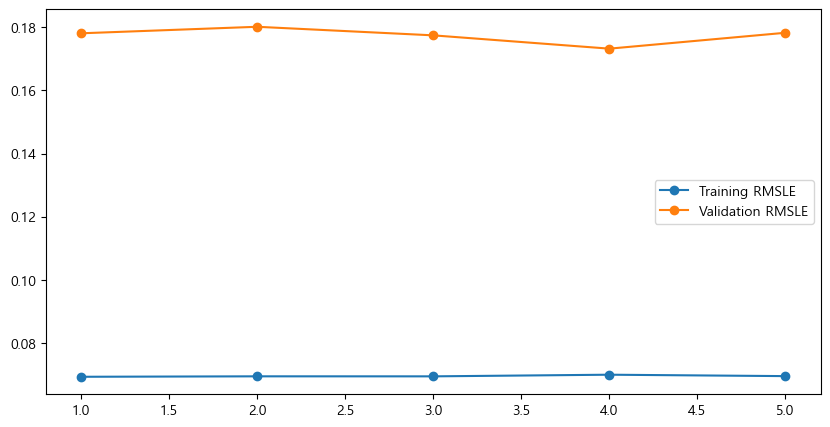

In [174]:
plt.figure(figsize=(10, 5))
plt.plot([1,2,3,4,5], rf_t_score, marker='o', label='Training RMSLE')
plt.plot([1,2,3,4,5], rf_v_score, marker='o', label='Validation RMSLE')
plt.legend()
plt.show()

## ExtraRegressor

In [175]:
start_time =time.time()
ex = ExtraTreesRegressor(n_jobs = -1, random_state = 42)
ex_reg = ex.fit(x_train,y_train)
ex_base_pred = ex_reg.predict(x_test)
print('EXTRA RMSLE: {0:.4f}'.format(rmsle( y_test,ex_base_pred)))
evaluate_regr(y_test,ex_base_pred)
params = {
    'n_estimators':[100,200,300,400],
    'max_depth':[10,15,19],
    'bootstrap':[True,False],
    'min_samples_split':[0.1,1],
    'max_features':[3,5,7,10,'sqrt', 'log2']
}
ex_grid_cv = GridSearchCV(ex,param_grid = params, cv=3,n_jobs=-1,scoring=rmsle_scorer).fit(x_train,y_train)

print('최적 하이퍼 파라미터:\n', ex_grid_cv.best_params_)
ex_praram = ex_grid_cv.best_params_
ex_pred = ex_grid_cv.best_estimator_.predict(x_test)

print('Extra RMSLE: {0:.4f}'.format(rmsle(y_test,ex_pred)))
print('수행속도 : {0:.1f}초'.format(time.time()-start_time))

EXTRA RMSLE: 0.1815
MAE: 0.369, RMSE: 0.472, RMSLE: 0.182
최적 하이퍼 파라미터:
 {'bootstrap': True, 'max_depth': 10, 'max_features': 3, 'min_samples_split': 0.1, 'n_estimators': 100}
Extra RMSLE: 0.1708
수행속도 : 250.4초


In [176]:
exk = ExtraTreesRegressor(n_jobs = -1, random_state = 42) #**ex_grid_cv.best_params_,

kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 각 fold의 모델로부터의 예측을 저장할 리스트와 MAE 점수 리스트
ensemble_predictions = []
ex_t_score = []
ex_v_score = []
for train_idx, val_idx in tqdm(kf.split(X_standard,y), total=5, desc="Processing folds"):
    X_t, X_val = X_standard[train_idx], X_standard[val_idx]
    y_t, y_val = y[train_idx], y[val_idx]
    
    # 두 모델 모두 학습
    exk.fit(X_t, y_t)
    
    # 각 모델로부터 Validation set에 대한 예측을 평균내어 앙상블 예측 생성
    val_pred = exk.predict(X_val)
    t_pred = exk.predict(X_t)
    # Validation set에 대한 대회 평가 산식 계산 후 저장
    ex_v_score.append(rmsle(y_val, val_pred))
    ex_t_score.append(rmsle(y_t, t_pred))
    # test 데이터셋에 대한 예측 수행 후 저장
    
    exk_pred = exk.predict(test_standard)
    exk_pred = np.where(exk_pred < 0, 0, exk_pred)
    
    ensemble_predictions.append(np.expm1(exk_pred))

# K-fold 모든 예측의 평균을 계산하여 fold별 모델들의 앙상블 예측 생성
exk_final_predictions = np.mean(ensemble_predictions, axis=0)

# 각 fold에서의 Validation Metric Score와 전체 평균 Validation Metric Score출력
print("Validation : RMSLE scores for each fold:", ex_v_score)
print("Validation : RMSLE:", np.mean(ex_v_score))

Processing folds: 100%|██████████████████████████████████████████████████████████████████| 5/5 [00:16<00:00,  3.24s/it]

Validation : RMSLE scores for each fold: [0.18299757305576997, 0.1855916952409403, 0.18413819078684882, 0.17892885170863185, 0.18414409928869685]
Validation : RMSLE: 0.18316008201617753


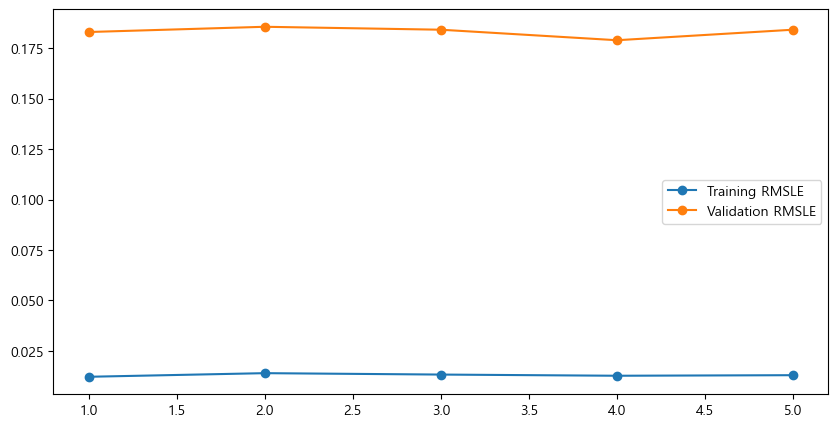

In [177]:
plt.figure(figsize=(10, 5))
plt.plot([1,2,3,4,5], ex_t_score, marker='o', label='Training RMSLE')
plt.plot([1,2,3,4,5], ex_v_score, marker='o', label='Validation RMSLE')
plt.legend()
plt.show()

## GradientboostingRegressor

In [178]:
start_time =time.time()
gb = GradientBoostingRegressor(random_state=42)
gb_clf = gb.fit(x_train , y_train)
gb_base_pred = gb_clf.predict(x_test)
evaluate_regr(y_test,gb_base_pred)
print('GBM RMSLE: {0:.4f}'.format(rmsle( y_test,gb_base_pred)))

params = {
    'n_estimators':[100,200,300,400],
    'learning_rate':[0.01,0.03,0.1],
    'max_depth':[10,15,19],
    'subsample':[0.7,0.75]
}
grid_cv = GridSearchCV(gb,param_grid = params, cv=3,n_jobs=-1,scoring=rmsle_scorer).fit(x_train,y_train)

print('최적 하이퍼 파라미터:\n', grid_cv.best_params_)
GBM_praram = grid_cv.best_params_
gbcv_pred = grid_cv.best_estimator_.predict(x_test)
print('GBM RMSLE: {0:.4f}'.format(rmsle(y_test,gbcv_pred)))
print('수행속도 : {0:.1f}초'.format(time.time()-start_time))


MAE: 0.351, RMSE: 0.440, RMSLE: 0.170
GBM RMSLE: 0.1699
최적 하이퍼 파라미터:
 {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 400, 'subsample': 0.7}
GBM RMSLE: 0.1914
수행속도 : 1227.8초


In [179]:
gbk = GradientBoostingRegressor(random_state = 42) # **grid_cv.best_params_

kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 각 fold의 모델로부터의 예측을 저장할 리스트와 MAE 점수 리스트
ensemble_predictions = []
gbk_t_score = []
gbk_v_score = []

for train_idx, val_idx in tqdm(kf.split(X_standard,y), total=5, desc="Processing folds"):
    X_t, X_val = X_standard[train_idx], X_standard[val_idx]
    y_t, y_val = y[train_idx], y[val_idx]
    
    # 두 모델 모두 학습
    gbk.fit(X_t, y_t)
    
    val_pred = gbk.predict(X_val)
    t_pred = gbk.predict(X_t)
    # Validation set에 대한 대회 평가 산식 계산 후 저장
    gbk_v_score.append(rmsle(y_val, val_pred))
    gbk_t_score.append(rmsle(y_t, t_pred))
    
    # test 데이터셋에 대한 예측 수행 후 저장
    gbk_pred = gbk.predict(test_standard)
    gbk_pred = np.where(gbk_pred < 0, 0, gbk_pred)
    
    ensemble_predictions.append(np.expm1(gbk_pred))

# K-fold 모든 예측의 평균을 계산하여 fold별 모델들의 앙상블 예측 생성
gbk_final_predictions = np.mean(ensemble_predictions, axis=0)

# 각 fold에서의 Validation Metric Score와 전체 평균 Validation Metric Score출력
print("Validation : RMSLE scores for each fold:", gbk_v_score)
print("Validation : RMSLE:", np.mean(gbk_v_score))

Processing folds: 100%|██████████████████████████████████████████████████████████████████| 5/5 [00:23<00:00,  4.60s/it]

Validation : RMSLE scores for each fold: [0.17174532157901437, 0.1745073139501853, 0.17178643442445515, 0.16666526219451896, 0.1704343982015485]
Validation : RMSLE: 0.17102774606994445


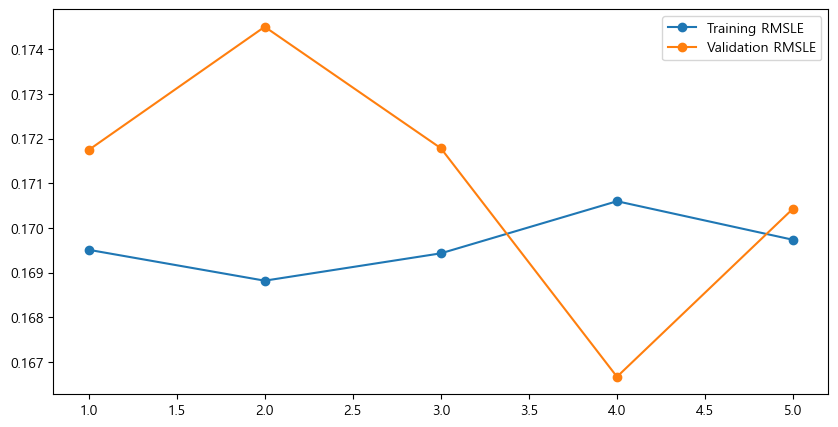

In [180]:
plt.figure(figsize=(10, 5))
plt.plot([1,2,3,4,5], gbk_t_score, marker='o', label='Training RMSLE')
plt.plot([1,2,3,4,5], gbk_v_score, marker='o', label='Validation RMSLE')
plt.legend()
plt.show()

## XGBRegressor

In [181]:
start_time = time.time()
xgb = XGBRegressor(random_state=42)
xgb_reg = xgb.fit(x_train, y_train)
xgb_base_pred = xgb_reg.predict(x_test)
print('XGB RMSLE: {0:.4f}'.format(rmsle(y_test, xgb_base_pred)))
evaluate_regr(y_test,xgb_base_pred)

xgb_param_grid={
    'learning_rate':[0.01,0.03,0.1],
    'eval_metric':['rmsle'],
#     'objective':['reg:squaredlogerror'] ,
    'n_estimators':[100,200,300,400], 
    'max_depth':[3,10,12]  
}
xgb_grid=GridSearchCV(xgb, param_grid = xgb_param_grid,cv=3, n_jobs=-1, scoring=rmsle_scorer, verbose = 2).fit(x_train, y_train)

print('최적 하이퍼 파라미터:\n', xgb_grid.best_params_)
xgb_praram = xgb_grid.best_params_
xgb_pred = xgb_grid.best_estimator_.predict(x_test)
print('XGB RMSLE: {0:.4f}'.format(rmsle(y_test,xgb_pred)))
print('수행속도 : {0:.1f}초'.format(time.time()-start_time))

XGB RMSLE: 0.1760
MAE: 0.360, RMSE: 0.457, RMSLE: 0.176
Fitting 3 folds for each of 36 candidates, totalling 108 fits
최적 하이퍼 파라미터:
 {'eval_metric': 'rmsle', 'learning_rate': 0.01, 'max_depth': 12, 'n_estimators': 100}
XGB RMSLE: 0.2340
수행속도 : 384.8초


In [182]:
xgbk = XGBRegressor(n_jobs = -1, random_state = 42)# **xgb_grid.best_params_,

kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 각 fold의 모델로부터의 예측을 저장할 리스트와 MAE 점수 리스트
ensemble_predictions = []
xgb_t_score = []
xgb_v_score = []
for train_idx, val_idx in tqdm(kf.split(X_standard,y), total=5, desc="Processing folds"):
    X_t, X_val = X_standard[train_idx], X_standard[val_idx]
    y_t, y_val = y[train_idx], y[val_idx]
    
    # 두 모델 모두 학습
    xgbk.fit(X_t, y_t)
    
    # 각 모델로부터 Validation set에 대한 예측을 평균내어 앙상블 예측 생성
    val_pred = xgbk.predict(X_val)
    t_pred = xgbk.predict(X_t)
    # Validation set에 대한 대회 평가 산식 계산 후 저장
    xgb_v_score.append(rmsle(y_val, val_pred))
    xgb_t_score.append(rmsle(y_t, t_pred))
    
    # test 데이터셋에 대한 예측 수행 후 저장
    xgbk_pred = xgbk.predict(test_standard)
    xgbk_pred = np.where(xgbk_pred < 0, 0, xgbk_pred)
    
    ensemble_predictions.append(np.expm1(xgbk_pred))

# K-fold 모든 예측의 평균을 계산하여 fold별 모델들의 앙상블 예측 생성
xgbk_final_predictions = np.mean(ensemble_predictions, axis=0)

# 각 fold에서의 Validation Metric Score와 전체 평균 Validation Metric Score출력
print("Validation : RMSLE scores for each fold:", xgb_v_score)
print("Validation : RMSLE:", np.mean(xgb_v_score))

Processing folds: 100%|██████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.34s/it]

Validation : RMSLE scores for each fold: [0.17652207496749603, 0.17979354461845556, 0.1769311823184779, 0.1725610841375993, 0.17681832392883973]
Validation : RMSLE: 0.17652524199417371


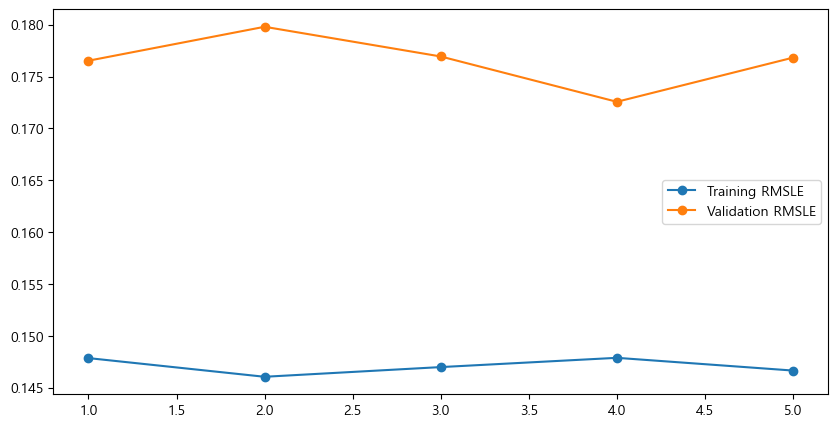

In [183]:
plt.figure(figsize=(10, 5))
plt.plot([1,2,3,4,5], xgb_t_score, marker='o', label='Training RMSLE')
plt.plot([1,2,3,4,5], xgb_v_score, marker='o', label='Validation RMSLE')
plt.legend()
plt.show()

## LGBMRegressor

In [184]:
start_time = time.time()
lgb = LGBMRegressor(random_state=42)
lgb_reg = lgb.fit(x_train,y_train)
lgb_base_pred = lgb.predict(x_test)
print('LightGBM RMSLE: {0:.4f}'.format(rmsle(y_test, lgb_base_pred)))
evaluate_regr(y_test,lgb_base_pred)

lgb_param = {'learning_rate':[0.01,0.03,0.1],
            'n_estimators':[100,200,300,400],
             'max_depth' : [3,10,15],
             'eval_metric':['rmsle'],
             'feature_fraction':[0.1,0.7],
             'bagging_fraction':[0.1,0.7]
            }

lgb_grid = GridSearchCV(lgb,param_grid = lgb_param, cv=3,n_jobs=-1,scoring=rmsle_scorer).fit(x_train,y_train)   # ,eval_metric='mlogloss'

print('최적 하이퍼 파라미터:\n', lgb_grid.best_params_)
lbg_praram = lgb_grid.best_params_
lgb_pred = lgb_grid.best_estimator_.predict(x_test)
print('LGB RMSLE: {0:.4f}'.format(rmsle(y_test,lgb_pred)))
print('수행속도 : {0:.1f}초'.format(time.time()-start_time))

LightGBM RMSLE: 0.1703
MAE: 0.351, RMSE: 0.441, RMSLE: 0.170
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.1, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1
최적 하이퍼 파라미터:
 {'bagging_fraction': 0.1, 'eval_metric': 'rmsle', 'feature_fraction': 0.7, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 400}
LGB RMSLE: 0.1721
수행속도 : 94.2초


In [185]:
lgbk = LGBMRegressor(n_jobs = -1, random_state = 42)
#**lgb_grid.best_params_
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 각 fold의 모델로부터의 예측을 저장할 리스트와 MAE 점수 리스트
ensemble_predictions = []
lgb_t_score = []
lgb_v_score = []

for train_idx, val_idx in tqdm(kf.split(X_standard,y), total=5, desc="Processing folds"):
    X_t, X_val = X_standard[train_idx], X_standard[val_idx]
    y_t, y_val = y[train_idx], y[val_idx]
    
    # 두 모델 모두 학습
    lgbk.fit(X_t, y_t)
    
    # 각 모델로부터 Validation set에 대한 예측을 평균내어 앙상블 예측 생성
    val_pred = lgbk.predict(X_val)
    t_pred = lgbk.predict(X_t)
    # Validation set에 대한 대회 평가 산식 계산 후 저장
    lgb_v_score.append(rmsle(y_val, val_pred))
    lgb_t_score.append(rmsle(y_t, t_pred))
    
    # test 데이터셋에 대한 예측 수행 후 저장
    lgbk_pred = lgbk.predict(test_standard)
    lgbk_pred = np.where(lgbk_pred < 0, 0, lgbk_pred)
    
    ensemble_predictions.append(np.expm1(lgbk_pred))

# K-fold 모든 예측의 평균을 계산하여 fold별 모델들의 앙상블 예측 생성
lgbk_final_predictions = np.mean(ensemble_predictions, axis=0)

# 각 fold에서의 Validation Metric Score와 전체 평균 Validation Metric Score출력
print("Validation : RMSLE scores for each fold:", lgb_v_score)
print("Validation : RMSLE:", np.mean(lgb_v_score))

Processing folds: 100%|██████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.44it/s]

Validation : RMSLE scores for each fold: [0.17208264030281742, 0.17500455915115087, 0.17216854868733744, 0.16695240838628328, 0.1714615540177086]
Validation : RMSLE: 0.17153394210905953


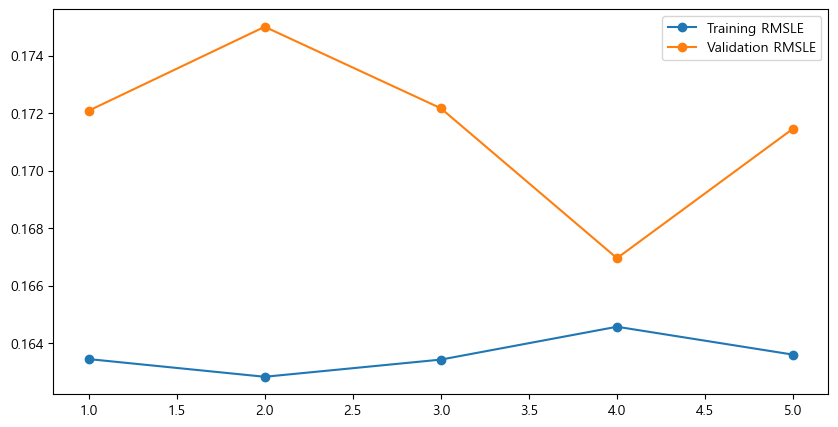

In [186]:
plt.figure(figsize=(10, 5))
plt.plot([1,2,3,4,5], lgb_t_score, marker='o', label='Training RMSLE')
plt.plot([1,2,3,4,5], lgb_v_score, marker='o', label='Validation RMSLE')
plt.legend()
plt.show()

## CatboostRegressor

In [187]:
cat = CatBoostRegressor(random_state=42)#.fit(x_train,y_train)
cat_reg = cat.fit(x_train,y_train)
cat_base_pred = cat.predict(x_test)
print('Catboost RMSLE: {0:.4f}'.format(rmsle(y_test, cat_base_pred)))
evaluate_regr(y_test,cat_base_pred)
parameters={'learning_rate': [0.03, 0.1],
        'depth': [4, 6, 10],
        'l2_leaf_reg': [1, 3, 5, 7, 9]}

catcv = GridSearchCV(cat, param_grid = parameters, cv = 3, n_jobs=-1).fit(x_train,y_train)#,scoring=rmsle_scorer
print('최적 하이퍼 파라미터:\n', catcv.best_params_)
catcv_praram = catcv.best_params_
catcv_pred = catcv.best_estimator_.predict(x_test)
print('catcv RMSLE: {0:.4f}'.format(rmsle(y_test,catcv_pred)))

Learning rate set to 0.070684
0:	learn: 0.4534978	total: 6.58ms	remaining: 6.57s
1:	learn: 0.4527254	total: 11.9ms	remaining: 5.92s
2:	learn: 0.4521838	total: 17.6ms	remaining: 5.86s
3:	learn: 0.4515285	total: 22.8ms	remaining: 5.68s
4:	learn: 0.4510534	total: 28.4ms	remaining: 5.65s
5:	learn: 0.4506013	total: 34.2ms	remaining: 5.67s
6:	learn: 0.4501032	total: 39.4ms	remaining: 5.59s
7:	learn: 0.4497933	total: 45ms	remaining: 5.58s
8:	learn: 0.4494083	total: 51ms	remaining: 5.61s
9:	learn: 0.4491152	total: 56.5ms	remaining: 5.6s
10:	learn: 0.4488228	total: 62.3ms	remaining: 5.61s
11:	learn: 0.4485981	total: 67.9ms	remaining: 5.59s
12:	learn: 0.4483448	total: 73.2ms	remaining: 5.55s
13:	learn: 0.4480923	total: 79ms	remaining: 5.56s
14:	learn: 0.4478801	total: 84.5ms	remaining: 5.54s
15:	learn: 0.4477346	total: 90.3ms	remaining: 5.55s
16:	learn: 0.4475737	total: 95.7ms	remaining: 5.53s
17:	learn: 0.4474097	total: 101ms	remaining: 5.52s
18:	learn: 0.4472825	total: 106ms	remaining: 5.48s
1

185:	learn: 0.4365576	total: 1.02s	remaining: 4.48s
186:	learn: 0.4365160	total: 1.03s	remaining: 4.47s
187:	learn: 0.4364633	total: 1.03s	remaining: 4.47s
188:	learn: 0.4364109	total: 1.04s	remaining: 4.46s
189:	learn: 0.4363382	total: 1.04s	remaining: 4.45s
190:	learn: 0.4362767	total: 1.05s	remaining: 4.45s
191:	learn: 0.4362215	total: 1.05s	remaining: 4.44s
192:	learn: 0.4361710	total: 1.06s	remaining: 4.43s
193:	learn: 0.4361197	total: 1.06s	remaining: 4.42s
194:	learn: 0.4360293	total: 1.07s	remaining: 4.42s
195:	learn: 0.4359769	total: 1.07s	remaining: 4.41s
196:	learn: 0.4359186	total: 1.08s	remaining: 4.41s
197:	learn: 0.4358485	total: 1.09s	remaining: 4.4s
198:	learn: 0.4357943	total: 1.09s	remaining: 4.39s
199:	learn: 0.4357210	total: 1.1s	remaining: 4.39s
200:	learn: 0.4356685	total: 1.1s	remaining: 4.38s
201:	learn: 0.4356011	total: 1.11s	remaining: 4.37s
202:	learn: 0.4355419	total: 1.11s	remaining: 4.37s
203:	learn: 0.4354797	total: 1.12s	remaining: 4.36s
204:	learn: 0.4

378:	learn: 0.4265772	total: 2.03s	remaining: 3.33s
379:	learn: 0.4265453	total: 2.04s	remaining: 3.33s
380:	learn: 0.4265161	total: 2.04s	remaining: 3.32s
381:	learn: 0.4264795	total: 2.05s	remaining: 3.31s
382:	learn: 0.4264339	total: 2.05s	remaining: 3.31s
383:	learn: 0.4263805	total: 2.06s	remaining: 3.3s
384:	learn: 0.4263317	total: 2.06s	remaining: 3.3s
385:	learn: 0.4262878	total: 2.07s	remaining: 3.29s
386:	learn: 0.4262420	total: 2.07s	remaining: 3.29s
387:	learn: 0.4261961	total: 2.08s	remaining: 3.28s
388:	learn: 0.4261479	total: 2.08s	remaining: 3.27s
389:	learn: 0.4261027	total: 2.09s	remaining: 3.27s
390:	learn: 0.4260592	total: 2.09s	remaining: 3.26s
391:	learn: 0.4260045	total: 2.1s	remaining: 3.26s
392:	learn: 0.4259659	total: 2.1s	remaining: 3.25s
393:	learn: 0.4259304	total: 2.11s	remaining: 3.24s
394:	learn: 0.4258880	total: 2.11s	remaining: 3.24s
395:	learn: 0.4258376	total: 2.12s	remaining: 3.23s
396:	learn: 0.4257919	total: 2.12s	remaining: 3.23s
397:	learn: 0.42

570:	learn: 0.4183490	total: 3.06s	remaining: 2.3s
571:	learn: 0.4182987	total: 3.06s	remaining: 2.29s
572:	learn: 0.4182545	total: 3.07s	remaining: 2.29s
573:	learn: 0.4182272	total: 3.07s	remaining: 2.28s
574:	learn: 0.4182080	total: 3.08s	remaining: 2.27s
575:	learn: 0.4181588	total: 3.08s	remaining: 2.27s
576:	learn: 0.4181378	total: 3.09s	remaining: 2.26s
577:	learn: 0.4180947	total: 3.09s	remaining: 2.26s
578:	learn: 0.4180427	total: 3.1s	remaining: 2.25s
579:	learn: 0.4180229	total: 3.1s	remaining: 2.25s
580:	learn: 0.4179784	total: 3.11s	remaining: 2.24s
581:	learn: 0.4179217	total: 3.11s	remaining: 2.23s
582:	learn: 0.4178862	total: 3.12s	remaining: 2.23s
583:	learn: 0.4178416	total: 3.12s	remaining: 2.22s
584:	learn: 0.4177921	total: 3.13s	remaining: 2.22s
585:	learn: 0.4177548	total: 3.13s	remaining: 2.21s
586:	learn: 0.4177374	total: 3.14s	remaining: 2.21s
587:	learn: 0.4176909	total: 3.14s	remaining: 2.2s
588:	learn: 0.4176434	total: 3.15s	remaining: 2.2s
589:	learn: 0.417

731:	learn: 0.4122403	total: 3.88s	remaining: 1.42s
732:	learn: 0.4122143	total: 3.89s	remaining: 1.42s
733:	learn: 0.4121690	total: 3.89s	remaining: 1.41s
734:	learn: 0.4121423	total: 3.9s	remaining: 1.41s
735:	learn: 0.4121132	total: 3.9s	remaining: 1.4s
736:	learn: 0.4120763	total: 3.91s	remaining: 1.4s
737:	learn: 0.4120362	total: 3.91s	remaining: 1.39s
738:	learn: 0.4120000	total: 3.92s	remaining: 1.38s
739:	learn: 0.4119595	total: 3.92s	remaining: 1.38s
740:	learn: 0.4119220	total: 3.93s	remaining: 1.37s
741:	learn: 0.4118973	total: 3.93s	remaining: 1.37s
742:	learn: 0.4118687	total: 3.94s	remaining: 1.36s
743:	learn: 0.4118411	total: 3.94s	remaining: 1.36s
744:	learn: 0.4117967	total: 3.95s	remaining: 1.35s
745:	learn: 0.4117696	total: 3.95s	remaining: 1.34s
746:	learn: 0.4117504	total: 3.96s	remaining: 1.34s
747:	learn: 0.4117166	total: 3.96s	remaining: 1.33s
748:	learn: 0.4116763	total: 3.97s	remaining: 1.33s
749:	learn: 0.4116446	total: 3.97s	remaining: 1.32s
750:	learn: 0.41

890:	learn: 0.4068091	total: 4.69s	remaining: 574ms
891:	learn: 0.4067593	total: 4.7s	remaining: 569ms
892:	learn: 0.4067355	total: 4.7s	remaining: 563ms
893:	learn: 0.4067083	total: 4.71s	remaining: 558ms
894:	learn: 0.4066815	total: 4.71s	remaining: 553ms
895:	learn: 0.4066557	total: 4.72s	remaining: 548ms
896:	learn: 0.4066321	total: 4.72s	remaining: 542ms
897:	learn: 0.4065825	total: 4.73s	remaining: 537ms
898:	learn: 0.4065397	total: 4.73s	remaining: 532ms
899:	learn: 0.4064956	total: 4.74s	remaining: 526ms
900:	learn: 0.4064623	total: 4.74s	remaining: 521ms
901:	learn: 0.4064327	total: 4.75s	remaining: 516ms
902:	learn: 0.4064010	total: 4.75s	remaining: 510ms
903:	learn: 0.4063583	total: 4.75s	remaining: 505ms
904:	learn: 0.4063184	total: 4.76s	remaining: 500ms
905:	learn: 0.4062728	total: 4.77s	remaining: 495ms
906:	learn: 0.4062430	total: 4.77s	remaining: 489ms
907:	learn: 0.4062005	total: 4.78s	remaining: 484ms
908:	learn: 0.4061633	total: 4.78s	remaining: 479ms
909:	learn: 0.

75:	learn: 0.4473896	total: 412ms	remaining: 5.01s
76:	learn: 0.4473665	total: 418ms	remaining: 5.01s
77:	learn: 0.4473461	total: 423ms	remaining: 5s
78:	learn: 0.4473144	total: 429ms	remaining: 5s
79:	learn: 0.4472879	total: 434ms	remaining: 4.99s
80:	learn: 0.4472539	total: 440ms	remaining: 4.99s
81:	learn: 0.4472253	total: 445ms	remaining: 4.98s
82:	learn: 0.4471998	total: 450ms	remaining: 4.97s
83:	learn: 0.4471753	total: 455ms	remaining: 4.96s
84:	learn: 0.4471549	total: 460ms	remaining: 4.96s
85:	learn: 0.4471249	total: 466ms	remaining: 4.95s
86:	learn: 0.4471007	total: 471ms	remaining: 4.94s
87:	learn: 0.4470706	total: 476ms	remaining: 4.93s
88:	learn: 0.4470462	total: 482ms	remaining: 4.93s
89:	learn: 0.4470258	total: 487ms	remaining: 4.92s
90:	learn: 0.4470055	total: 492ms	remaining: 4.92s
91:	learn: 0.4469895	total: 498ms	remaining: 4.91s
92:	learn: 0.4469734	total: 503ms	remaining: 4.9s
93:	learn: 0.4469535	total: 508ms	remaining: 4.9s
94:	learn: 0.4469357	total: 513ms	remai

259:	learn: 0.4448051	total: 1.38s	remaining: 3.93s
260:	learn: 0.4447927	total: 1.39s	remaining: 3.93s
261:	learn: 0.4447753	total: 1.39s	remaining: 3.92s
262:	learn: 0.4447648	total: 1.4s	remaining: 3.92s
263:	learn: 0.4447550	total: 1.4s	remaining: 3.91s
264:	learn: 0.4447424	total: 1.41s	remaining: 3.9s
265:	learn: 0.4447342	total: 1.41s	remaining: 3.9s
266:	learn: 0.4447253	total: 1.42s	remaining: 3.89s
267:	learn: 0.4447118	total: 1.42s	remaining: 3.88s
268:	learn: 0.4447028	total: 1.43s	remaining: 3.88s
269:	learn: 0.4446946	total: 1.43s	remaining: 3.87s
270:	learn: 0.4446807	total: 1.44s	remaining: 3.87s
271:	learn: 0.4446740	total: 1.44s	remaining: 3.86s
272:	learn: 0.4446643	total: 1.45s	remaining: 3.85s
273:	learn: 0.4446539	total: 1.45s	remaining: 3.85s
274:	learn: 0.4446451	total: 1.46s	remaining: 3.84s
275:	learn: 0.4446389	total: 1.46s	remaining: 3.84s
276:	learn: 0.4446309	total: 1.47s	remaining: 3.83s
277:	learn: 0.4446241	total: 1.47s	remaining: 3.83s
278:	learn: 0.44

454:	learn: 0.4428701	total: 2.38s	remaining: 2.85s
455:	learn: 0.4428602	total: 2.39s	remaining: 2.85s
456:	learn: 0.4428501	total: 2.39s	remaining: 2.84s
457:	learn: 0.4428398	total: 2.4s	remaining: 2.84s
458:	learn: 0.4428299	total: 2.4s	remaining: 2.83s
459:	learn: 0.4428195	total: 2.41s	remaining: 2.83s
460:	learn: 0.4428098	total: 2.41s	remaining: 2.82s
461:	learn: 0.4428047	total: 2.42s	remaining: 2.82s
462:	learn: 0.4427895	total: 2.42s	remaining: 2.81s
463:	learn: 0.4427763	total: 2.43s	remaining: 2.81s
464:	learn: 0.4427655	total: 2.43s	remaining: 2.8s
465:	learn: 0.4427526	total: 2.44s	remaining: 2.79s
466:	learn: 0.4427409	total: 2.44s	remaining: 2.79s
467:	learn: 0.4427291	total: 2.45s	remaining: 2.78s
468:	learn: 0.4427181	total: 2.45s	remaining: 2.78s
469:	learn: 0.4427074	total: 2.46s	remaining: 2.77s
470:	learn: 0.4426939	total: 2.46s	remaining: 2.77s
471:	learn: 0.4426849	total: 2.47s	remaining: 2.76s
472:	learn: 0.4426747	total: 2.48s	remaining: 2.76s
473:	learn: 0.4

637:	learn: 0.4411145	total: 3.38s	remaining: 1.92s
638:	learn: 0.4411101	total: 3.38s	remaining: 1.91s
639:	learn: 0.4411031	total: 3.39s	remaining: 1.91s
640:	learn: 0.4410937	total: 3.39s	remaining: 1.9s
641:	learn: 0.4410855	total: 3.4s	remaining: 1.89s
642:	learn: 0.4410700	total: 3.4s	remaining: 1.89s
643:	learn: 0.4410619	total: 3.41s	remaining: 1.88s
644:	learn: 0.4410539	total: 3.41s	remaining: 1.88s
645:	learn: 0.4410466	total: 3.42s	remaining: 1.87s
646:	learn: 0.4410354	total: 3.42s	remaining: 1.87s
647:	learn: 0.4410278	total: 3.43s	remaining: 1.86s
648:	learn: 0.4410195	total: 3.43s	remaining: 1.85s
649:	learn: 0.4410137	total: 3.44s	remaining: 1.85s
650:	learn: 0.4410060	total: 3.44s	remaining: 1.84s
651:	learn: 0.4409966	total: 3.44s	remaining: 1.84s
652:	learn: 0.4409870	total: 3.45s	remaining: 1.83s
653:	learn: 0.4409770	total: 3.46s	remaining: 1.83s
654:	learn: 0.4409687	total: 3.46s	remaining: 1.82s
655:	learn: 0.4409594	total: 3.46s	remaining: 1.82s
656:	learn: 0.4

800:	learn: 0.4397831	total: 4.19s	remaining: 1.04s
801:	learn: 0.4397753	total: 4.2s	remaining: 1.04s
802:	learn: 0.4397668	total: 4.2s	remaining: 1.03s
803:	learn: 0.4397601	total: 4.21s	remaining: 1.02s
804:	learn: 0.4397499	total: 4.21s	remaining: 1.02s
805:	learn: 0.4397413	total: 4.22s	remaining: 1.01s
806:	learn: 0.4397339	total: 4.22s	remaining: 1.01s
807:	learn: 0.4397256	total: 4.23s	remaining: 1s
808:	learn: 0.4397165	total: 4.23s	remaining: 1000ms
809:	learn: 0.4397084	total: 4.24s	remaining: 994ms
810:	learn: 0.4397021	total: 4.24s	remaining: 989ms
811:	learn: 0.4396923	total: 4.25s	remaining: 983ms
812:	learn: 0.4396862	total: 4.25s	remaining: 978ms
813:	learn: 0.4396755	total: 4.26s	remaining: 973ms
814:	learn: 0.4396672	total: 4.26s	remaining: 967ms
815:	learn: 0.4396594	total: 4.27s	remaining: 962ms
816:	learn: 0.4396534	total: 4.27s	remaining: 957ms
817:	learn: 0.4396450	total: 4.28s	remaining: 951ms
818:	learn: 0.4396312	total: 4.28s	remaining: 946ms
819:	learn: 0.43

965:	learn: 0.4385242	total: 4.98s	remaining: 175ms
966:	learn: 0.4385173	total: 4.99s	remaining: 170ms
967:	learn: 0.4385114	total: 4.99s	remaining: 165ms
968:	learn: 0.4385066	total: 5s	remaining: 160ms
969:	learn: 0.4384953	total: 5s	remaining: 155ms
970:	learn: 0.4384889	total: 5s	remaining: 149ms
971:	learn: 0.4384793	total: 5.01s	remaining: 144ms
972:	learn: 0.4384740	total: 5.01s	remaining: 139ms
973:	learn: 0.4384687	total: 5.02s	remaining: 134ms
974:	learn: 0.4384635	total: 5.02s	remaining: 129ms
975:	learn: 0.4384541	total: 5.03s	remaining: 124ms
976:	learn: 0.4384466	total: 5.03s	remaining: 119ms
977:	learn: 0.4384407	total: 5.04s	remaining: 113ms
978:	learn: 0.4384347	total: 5.04s	remaining: 108ms
979:	learn: 0.4384268	total: 5.05s	remaining: 103ms
980:	learn: 0.4384177	total: 5.05s	remaining: 97.9ms
981:	learn: 0.4384085	total: 5.06s	remaining: 92.7ms
982:	learn: 0.4383997	total: 5.06s	remaining: 87.6ms
983:	learn: 0.4383910	total: 5.07s	remaining: 82.4ms
984:	learn: 0.438

In [188]:
catk =  CatBoostRegressor(random_state = 42) # **catcv_praram

kf = KFold(n_splits=5, shuffle=True)

# 각 fold의 모델로부터의 예측을 저장할 리스트와 MAE 점수 리스트
ensemble_predictions = []
cat_t_score = []
cat_v_score = []
for train_idx, val_idx in tqdm(kf.split(X_standard,y), total=5, desc="Processing folds"):
    X_t, X_val = X_standard[train_idx], X_standard[val_idx]
    y_t, y_val = y[train_idx], y[val_idx]
    
    # 두 모델 모두 학습
    catk.fit(X_t, y_t)
    
    # 각 모델로부터 Validation set에 대한 예측을 평균내어 앙상블 예측 생성
    val_pred = catk.predict(X_val)
    t_pred = catk.predict(X_t)
    # Validation set에 대한 대회 평가 산식 계산 후 저장
    cat_v_score.append(rmsle(y_val, val_pred))
    cat_t_score.append(rmsle(y_t, t_pred))
    
    # test 데이터셋에 대한 예측 수행 후 저장
    catk_pred = catk.predict(test_standard)
    catk_pred = np.where(catk_pred < 0, 0, catk_pred)
    
    ensemble_predictions.append(np.expm1(catk_pred))

# K-fold 모든 예측의 평균을 계산하여 fold별 모델들의 앙상블 예측 생성
catk_final_predictions = np.mean(ensemble_predictions, axis=0)

# 각 fold에서의 Validation Metric Score와 전체 평균 Validation Metric Score출력
print("Validation : RMSLE scores for each fold:", cat_v_score)
print("Validation : RMSLE:", np.mean(cat_v_score))

Processing folds:   0%|                                                                          | 0/5 [00:00<?, ?it/s]

Learning rate set to 0.070684
0:	learn: 0.4506991	total: 10.4ms	remaining: 10.4s
1:	learn: 0.4499828	total: 16.6ms	remaining: 8.26s
2:	learn: 0.4494469	total: 22.6ms	remaining: 7.52s
3:	learn: 0.4488874	total: 28.9ms	remaining: 7.2s
4:	learn: 0.4484426	total: 34.6ms	remaining: 6.88s
5:	learn: 0.4480400	total: 40.7ms	remaining: 6.74s
6:	learn: 0.4475745	total: 46.8ms	remaining: 6.63s
7:	learn: 0.4473022	total: 52.8ms	remaining: 6.54s
8:	learn: 0.4469722	total: 59.1ms	remaining: 6.51s
9:	learn: 0.4467095	total: 65.1ms	remaining: 6.45s
10:	learn: 0.4464673	total: 71.5ms	remaining: 6.43s
11:	learn: 0.4462651	total: 77.4ms	remaining: 6.38s
12:	learn: 0.4460369	total: 83.2ms	remaining: 6.31s
13:	learn: 0.4458116	total: 89.4ms	remaining: 6.3s
14:	learn: 0.4456011	total: 95.5ms	remaining: 6.27s
15:	learn: 0.4454370	total: 102ms	remaining: 6.26s
16:	learn: 0.4452806	total: 108ms	remaining: 6.24s
17:	learn: 0.4451218	total: 114ms	remaining: 6.24s
18:	learn: 0.4450033	total: 121ms	remaining: 6.23

162:	learn: 0.4358969	total: 1.03s	remaining: 5.28s
163:	learn: 0.4358193	total: 1.03s	remaining: 5.28s
164:	learn: 0.4357575	total: 1.04s	remaining: 5.27s
165:	learn: 0.4357039	total: 1.05s	remaining: 5.26s
166:	learn: 0.4356467	total: 1.05s	remaining: 5.26s
167:	learn: 0.4355957	total: 1.06s	remaining: 5.25s
168:	learn: 0.4355520	total: 1.07s	remaining: 5.24s
169:	learn: 0.4354785	total: 1.07s	remaining: 5.24s
170:	learn: 0.4354113	total: 1.08s	remaining: 5.23s
171:	learn: 0.4353522	total: 1.08s	remaining: 5.22s
172:	learn: 0.4352832	total: 1.09s	remaining: 5.22s
173:	learn: 0.4352430	total: 1.1s	remaining: 5.21s
174:	learn: 0.4351764	total: 1.1s	remaining: 5.21s
175:	learn: 0.4351122	total: 1.11s	remaining: 5.2s
176:	learn: 0.4350487	total: 1.12s	remaining: 5.19s
177:	learn: 0.4349954	total: 1.12s	remaining: 5.19s
178:	learn: 0.4349218	total: 1.13s	remaining: 5.18s
179:	learn: 0.4348916	total: 1.14s	remaining: 5.17s
180:	learn: 0.4348548	total: 1.14s	remaining: 5.17s
181:	learn: 0.4

323:	learn: 0.4272779	total: 2.06s	remaining: 4.29s
324:	learn: 0.4272219	total: 2.06s	remaining: 4.29s
325:	learn: 0.4271691	total: 2.07s	remaining: 4.28s
326:	learn: 0.4271271	total: 2.08s	remaining: 4.27s
327:	learn: 0.4270689	total: 2.08s	remaining: 4.27s
328:	learn: 0.4270224	total: 2.09s	remaining: 4.26s
329:	learn: 0.4269767	total: 2.1s	remaining: 4.26s
330:	learn: 0.4269376	total: 2.1s	remaining: 4.25s
331:	learn: 0.4268931	total: 2.11s	remaining: 4.24s
332:	learn: 0.4268304	total: 2.12s	remaining: 4.24s
333:	learn: 0.4267824	total: 2.12s	remaining: 4.23s
334:	learn: 0.4267379	total: 2.13s	remaining: 4.23s
335:	learn: 0.4266908	total: 2.14s	remaining: 4.22s
336:	learn: 0.4266527	total: 2.14s	remaining: 4.22s
337:	learn: 0.4265990	total: 2.15s	remaining: 4.21s
338:	learn: 0.4265508	total: 2.15s	remaining: 4.2s
339:	learn: 0.4264953	total: 2.16s	remaining: 4.2s
340:	learn: 0.4264603	total: 2.17s	remaining: 4.19s
341:	learn: 0.4264223	total: 2.18s	remaining: 4.19s
342:	learn: 0.42

482:	learn: 0.4200491	total: 3.07s	remaining: 3.28s
483:	learn: 0.4200129	total: 3.07s	remaining: 3.27s
484:	learn: 0.4199781	total: 3.08s	remaining: 3.27s
485:	learn: 0.4199179	total: 3.08s	remaining: 3.26s
486:	learn: 0.4198994	total: 3.09s	remaining: 3.25s
487:	learn: 0.4198580	total: 3.1s	remaining: 3.25s
488:	learn: 0.4198263	total: 3.1s	remaining: 3.24s
489:	learn: 0.4197843	total: 3.11s	remaining: 3.24s
490:	learn: 0.4197468	total: 3.12s	remaining: 3.23s
491:	learn: 0.4197054	total: 3.12s	remaining: 3.22s
492:	learn: 0.4196602	total: 3.13s	remaining: 3.22s
493:	learn: 0.4196072	total: 3.13s	remaining: 3.21s
494:	learn: 0.4195674	total: 3.14s	remaining: 3.21s
495:	learn: 0.4195054	total: 3.15s	remaining: 3.2s
496:	learn: 0.4194548	total: 3.15s	remaining: 3.19s
497:	learn: 0.4194167	total: 3.16s	remaining: 3.19s
498:	learn: 0.4193780	total: 3.17s	remaining: 3.18s
499:	learn: 0.4193429	total: 3.17s	remaining: 3.17s
500:	learn: 0.4192820	total: 3.18s	remaining: 3.17s
501:	learn: 0.4

671:	learn: 0.4123799	total: 4.28s	remaining: 2.09s
672:	learn: 0.4123422	total: 4.29s	remaining: 2.08s
673:	learn: 0.4123039	total: 4.3s	remaining: 2.08s
674:	learn: 0.4122701	total: 4.3s	remaining: 2.07s
675:	learn: 0.4122395	total: 4.31s	remaining: 2.06s
676:	learn: 0.4122102	total: 4.32s	remaining: 2.06s
677:	learn: 0.4121653	total: 4.32s	remaining: 2.05s
678:	learn: 0.4121317	total: 4.33s	remaining: 2.05s
679:	learn: 0.4120846	total: 4.33s	remaining: 2.04s
680:	learn: 0.4120484	total: 4.34s	remaining: 2.03s
681:	learn: 0.4120073	total: 4.35s	remaining: 2.03s
682:	learn: 0.4119619	total: 4.35s	remaining: 2.02s
683:	learn: 0.4119352	total: 4.36s	remaining: 2.01s
684:	learn: 0.4118969	total: 4.37s	remaining: 2.01s
685:	learn: 0.4118824	total: 4.37s	remaining: 2s
686:	learn: 0.4118382	total: 4.38s	remaining: 2s
687:	learn: 0.4117903	total: 4.39s	remaining: 1.99s
688:	learn: 0.4117460	total: 4.39s	remaining: 1.98s
689:	learn: 0.4117214	total: 4.4s	remaining: 1.98s
690:	learn: 0.4116711

830:	learn: 0.4068377	total: 5.32s	remaining: 1.08s
831:	learn: 0.4068062	total: 5.33s	remaining: 1.07s
832:	learn: 0.4067752	total: 5.33s	remaining: 1.07s
833:	learn: 0.4067415	total: 5.34s	remaining: 1.06s
834:	learn: 0.4067116	total: 5.35s	remaining: 1.06s
835:	learn: 0.4066812	total: 5.35s	remaining: 1.05s
836:	learn: 0.4066528	total: 5.36s	remaining: 1.04s
837:	learn: 0.4066217	total: 5.37s	remaining: 1.04s
838:	learn: 0.4065776	total: 5.37s	remaining: 1.03s
839:	learn: 0.4065205	total: 5.38s	remaining: 1.02s
840:	learn: 0.4064839	total: 5.39s	remaining: 1.02s
841:	learn: 0.4064473	total: 5.39s	remaining: 1.01s
842:	learn: 0.4064184	total: 5.4s	remaining: 1s
843:	learn: 0.4063730	total: 5.4s	remaining: 999ms
844:	learn: 0.4063366	total: 5.41s	remaining: 993ms
845:	learn: 0.4062850	total: 5.42s	remaining: 986ms
846:	learn: 0.4062441	total: 5.42s	remaining: 980ms
847:	learn: 0.4062175	total: 5.43s	remaining: 973ms
848:	learn: 0.4061814	total: 5.43s	remaining: 967ms
849:	learn: 0.406

Processing folds:  20%|█████████████▏                                                    | 1/5 [00:07<00:29,  7.36s/it]

Learning rate set to 0.070684
0:	learn: 0.4537844	total: 6.32ms	remaining: 6.31s
1:	learn: 0.4529622	total: 11.7ms	remaining: 5.82s
2:	learn: 0.4523242	total: 16.8ms	remaining: 5.58s
3:	learn: 0.4517123	total: 22.3ms	remaining: 5.54s
4:	learn: 0.4512119	total: 27.2ms	remaining: 5.42s
5:	learn: 0.4507498	total: 32.7ms	remaining: 5.42s
6:	learn: 0.4502524	total: 38.2ms	remaining: 5.42s
7:	learn: 0.4499440	total: 43.4ms	remaining: 5.39s
8:	learn: 0.4495974	total: 48.8ms	remaining: 5.37s
9:	learn: 0.4493076	total: 54.2ms	remaining: 5.36s
10:	learn: 0.4490061	total: 59.4ms	remaining: 5.34s
11:	learn: 0.4487458	total: 65ms	remaining: 5.36s
12:	learn: 0.4484974	total: 71.1ms	remaining: 5.39s
13:	learn: 0.4482686	total: 76.7ms	remaining: 5.4s
14:	learn: 0.4480731	total: 82.1ms	remaining: 5.39s
15:	learn: 0.4479025	total: 87.5ms	remaining: 5.38s
16:	learn: 0.4477227	total: 92.8ms	remaining: 5.36s
17:	learn: 0.4475654	total: 98.2ms	remaining: 5.36s
18:	learn: 0.4474222	total: 104ms	remaining: 5.

179:	learn: 0.4372520	total: 1.02s	remaining: 4.66s
180:	learn: 0.4372030	total: 1.03s	remaining: 4.66s
181:	learn: 0.4371500	total: 1.03s	remaining: 4.65s
182:	learn: 0.4370885	total: 1.04s	remaining: 4.65s
183:	learn: 0.4370227	total: 1.05s	remaining: 4.64s
184:	learn: 0.4369520	total: 1.05s	remaining: 4.63s
185:	learn: 0.4368823	total: 1.06s	remaining: 4.63s
186:	learn: 0.4368131	total: 1.06s	remaining: 4.62s
187:	learn: 0.4367367	total: 1.07s	remaining: 4.61s
188:	learn: 0.4366566	total: 1.07s	remaining: 4.61s
189:	learn: 0.4366221	total: 1.08s	remaining: 4.6s
190:	learn: 0.4365750	total: 1.08s	remaining: 4.59s
191:	learn: 0.4365313	total: 1.09s	remaining: 4.59s
192:	learn: 0.4364593	total: 1.09s	remaining: 4.58s
193:	learn: 0.4363942	total: 1.1s	remaining: 4.58s
194:	learn: 0.4363246	total: 1.11s	remaining: 4.57s
195:	learn: 0.4362687	total: 1.11s	remaining: 4.56s
196:	learn: 0.4362109	total: 1.12s	remaining: 4.56s
197:	learn: 0.4361448	total: 1.12s	remaining: 4.55s
198:	learn: 0.

355:	learn: 0.4280699	total: 2.02s	remaining: 3.65s
356:	learn: 0.4280382	total: 2.02s	remaining: 3.64s
357:	learn: 0.4279718	total: 2.03s	remaining: 3.64s
358:	learn: 0.4279311	total: 2.03s	remaining: 3.63s
359:	learn: 0.4278852	total: 2.04s	remaining: 3.62s
360:	learn: 0.4278430	total: 2.04s	remaining: 3.62s
361:	learn: 0.4278045	total: 2.05s	remaining: 3.61s
362:	learn: 0.4277629	total: 2.05s	remaining: 3.6s
363:	learn: 0.4277271	total: 2.06s	remaining: 3.6s
364:	learn: 0.4276736	total: 2.06s	remaining: 3.59s
365:	learn: 0.4276156	total: 2.07s	remaining: 3.59s
366:	learn: 0.4275625	total: 2.08s	remaining: 3.58s
367:	learn: 0.4275318	total: 2.08s	remaining: 3.58s
368:	learn: 0.4274940	total: 2.09s	remaining: 3.57s
369:	learn: 0.4274400	total: 2.09s	remaining: 3.56s
370:	learn: 0.4273849	total: 2.1s	remaining: 3.56s
371:	learn: 0.4273314	total: 2.1s	remaining: 3.55s
372:	learn: 0.4272801	total: 2.11s	remaining: 3.54s
373:	learn: 0.4272357	total: 2.11s	remaining: 3.54s
374:	learn: 0.42

536:	learn: 0.4199355	total: 3.03s	remaining: 2.62s
537:	learn: 0.4198972	total: 3.04s	remaining: 2.61s
538:	learn: 0.4198635	total: 3.05s	remaining: 2.6s
539:	learn: 0.4198220	total: 3.05s	remaining: 2.6s
540:	learn: 0.4197621	total: 3.06s	remaining: 2.59s
541:	learn: 0.4197075	total: 3.06s	remaining: 2.59s
542:	learn: 0.4196682	total: 3.07s	remaining: 2.58s
543:	learn: 0.4196234	total: 3.07s	remaining: 2.58s
544:	learn: 0.4195812	total: 3.08s	remaining: 2.57s
545:	learn: 0.4195426	total: 3.08s	remaining: 2.56s
546:	learn: 0.4194948	total: 3.09s	remaining: 2.56s
547:	learn: 0.4194692	total: 3.1s	remaining: 2.55s
548:	learn: 0.4194388	total: 3.1s	remaining: 2.55s
549:	learn: 0.4193967	total: 3.11s	remaining: 2.54s
550:	learn: 0.4193622	total: 3.11s	remaining: 2.54s
551:	learn: 0.4193196	total: 3.12s	remaining: 2.53s
552:	learn: 0.4192916	total: 3.13s	remaining: 2.53s
553:	learn: 0.4192548	total: 3.13s	remaining: 2.52s
554:	learn: 0.4192175	total: 3.14s	remaining: 2.52s
555:	learn: 0.41

717:	learn: 0.4127983	total: 4.05s	remaining: 1.59s
718:	learn: 0.4127859	total: 4.05s	remaining: 1.58s
719:	learn: 0.4127580	total: 4.06s	remaining: 1.58s
720:	learn: 0.4127375	total: 4.07s	remaining: 1.57s
721:	learn: 0.4126975	total: 4.07s	remaining: 1.57s
722:	learn: 0.4126529	total: 4.08s	remaining: 1.56s
723:	learn: 0.4126241	total: 4.08s	remaining: 1.56s
724:	learn: 0.4125743	total: 4.09s	remaining: 1.55s
725:	learn: 0.4125159	total: 4.09s	remaining: 1.54s
726:	learn: 0.4124836	total: 4.1s	remaining: 1.54s
727:	learn: 0.4124467	total: 4.1s	remaining: 1.53s
728:	learn: 0.4124292	total: 4.11s	remaining: 1.53s
729:	learn: 0.4123811	total: 4.11s	remaining: 1.52s
730:	learn: 0.4123403	total: 4.12s	remaining: 1.52s
731:	learn: 0.4123172	total: 4.13s	remaining: 1.51s
732:	learn: 0.4122692	total: 4.13s	remaining: 1.5s
733:	learn: 0.4122261	total: 4.14s	remaining: 1.5s
734:	learn: 0.4121807	total: 4.14s	remaining: 1.49s
735:	learn: 0.4121279	total: 4.15s	remaining: 1.49s
736:	learn: 0.41

907:	learn: 0.4060069	total: 5.06s	remaining: 512ms
908:	learn: 0.4059567	total: 5.06s	remaining: 507ms
909:	learn: 0.4059162	total: 5.07s	remaining: 501ms
910:	learn: 0.4058953	total: 5.07s	remaining: 496ms
911:	learn: 0.4058584	total: 5.08s	remaining: 490ms
912:	learn: 0.4058257	total: 5.08s	remaining: 485ms
913:	learn: 0.4057936	total: 5.09s	remaining: 479ms
914:	learn: 0.4057553	total: 5.09s	remaining: 473ms
915:	learn: 0.4057437	total: 5.1s	remaining: 468ms
916:	learn: 0.4057061	total: 5.11s	remaining: 462ms
917:	learn: 0.4056926	total: 5.11s	remaining: 456ms
918:	learn: 0.4056544	total: 5.12s	remaining: 451ms
919:	learn: 0.4056322	total: 5.12s	remaining: 445ms
920:	learn: 0.4056043	total: 5.12s	remaining: 440ms
921:	learn: 0.4055758	total: 5.13s	remaining: 434ms
922:	learn: 0.4055431	total: 5.13s	remaining: 428ms
923:	learn: 0.4055193	total: 5.14s	remaining: 423ms
924:	learn: 0.4055058	total: 5.14s	remaining: 417ms
925:	learn: 0.4054605	total: 5.15s	remaining: 412ms
926:	learn: 0

Processing folds:  40%|██████████████████████████▍                                       | 2/5 [00:13<00:20,  6.76s/it]

Learning rate set to 0.070684
0:	learn: 0.4529429	total: 4.75ms	remaining: 4.74s
1:	learn: 0.4521301	total: 9.32ms	remaining: 4.65s
2:	learn: 0.4515084	total: 13.9ms	remaining: 4.63s
3:	learn: 0.4509139	total: 18.3ms	remaining: 4.56s
4:	learn: 0.4504428	total: 22.2ms	remaining: 4.41s
5:	learn: 0.4500617	total: 26.4ms	remaining: 4.38s
6:	learn: 0.4495709	total: 31ms	remaining: 4.4s
7:	learn: 0.4492723	total: 35.4ms	remaining: 4.39s
8:	learn: 0.4489220	total: 40.1ms	remaining: 4.42s
9:	learn: 0.4486359	total: 45ms	remaining: 4.46s
10:	learn: 0.4483506	total: 49.9ms	remaining: 4.49s
11:	learn: 0.4481339	total: 54.5ms	remaining: 4.49s
12:	learn: 0.4479045	total: 59.5ms	remaining: 4.52s
13:	learn: 0.4476391	total: 64.3ms	remaining: 4.53s
14:	learn: 0.4474679	total: 69.1ms	remaining: 4.54s
15:	learn: 0.4473221	total: 73.9ms	remaining: 4.55s
16:	learn: 0.4471643	total: 78.5ms	remaining: 4.54s
17:	learn: 0.4470000	total: 83.3ms	remaining: 4.55s
18:	learn: 0.4468715	total: 88.4ms	remaining: 4.5

159:	learn: 0.4379421	total: 812ms	remaining: 4.26s
160:	learn: 0.4378840	total: 819ms	remaining: 4.27s
161:	learn: 0.4378089	total: 824ms	remaining: 4.26s
162:	learn: 0.4377498	total: 830ms	remaining: 4.26s
163:	learn: 0.4376680	total: 836ms	remaining: 4.26s
164:	learn: 0.4375941	total: 841ms	remaining: 4.25s
165:	learn: 0.4375227	total: 846ms	remaining: 4.25s
166:	learn: 0.4374535	total: 851ms	remaining: 4.25s
167:	learn: 0.4373887	total: 856ms	remaining: 4.24s
168:	learn: 0.4373445	total: 862ms	remaining: 4.24s
169:	learn: 0.4372917	total: 867ms	remaining: 4.23s
170:	learn: 0.4372531	total: 872ms	remaining: 4.23s
171:	learn: 0.4371903	total: 877ms	remaining: 4.22s
172:	learn: 0.4371525	total: 883ms	remaining: 4.22s
173:	learn: 0.4370862	total: 888ms	remaining: 4.21s
174:	learn: 0.4370379	total: 893ms	remaining: 4.21s
175:	learn: 0.4369918	total: 899ms	remaining: 4.21s
176:	learn: 0.4369223	total: 904ms	remaining: 4.2s
177:	learn: 0.4368411	total: 909ms	remaining: 4.2s
178:	learn: 0.

356:	learn: 0.4272382	total: 1.83s	remaining: 3.31s
357:	learn: 0.4272032	total: 1.84s	remaining: 3.3s
358:	learn: 0.4271700	total: 1.84s	remaining: 3.29s
359:	learn: 0.4271282	total: 1.85s	remaining: 3.29s
360:	learn: 0.4270852	total: 1.85s	remaining: 3.28s
361:	learn: 0.4270428	total: 1.86s	remaining: 3.28s
362:	learn: 0.4269893	total: 1.86s	remaining: 3.27s
363:	learn: 0.4269416	total: 1.87s	remaining: 3.27s
364:	learn: 0.4268840	total: 1.87s	remaining: 3.26s
365:	learn: 0.4268290	total: 1.88s	remaining: 3.25s
366:	learn: 0.4267867	total: 1.88s	remaining: 3.25s
367:	learn: 0.4267461	total: 1.89s	remaining: 3.24s
368:	learn: 0.4267055	total: 1.89s	remaining: 3.24s
369:	learn: 0.4266599	total: 1.9s	remaining: 3.23s
370:	learn: 0.4266168	total: 1.9s	remaining: 3.23s
371:	learn: 0.4265802	total: 1.91s	remaining: 3.22s
372:	learn: 0.4265475	total: 1.91s	remaining: 3.22s
373:	learn: 0.4264768	total: 1.92s	remaining: 3.21s
374:	learn: 0.4264401	total: 1.92s	remaining: 3.21s
375:	learn: 0.4

550:	learn: 0.4187024	total: 2.84s	remaining: 2.31s
551:	learn: 0.4186814	total: 2.85s	remaining: 2.31s
552:	learn: 0.4186509	total: 2.85s	remaining: 2.3s
553:	learn: 0.4185993	total: 2.85s	remaining: 2.3s
554:	learn: 0.4185764	total: 2.86s	remaining: 2.29s
555:	learn: 0.4185293	total: 2.87s	remaining: 2.29s
556:	learn: 0.4184944	total: 2.87s	remaining: 2.28s
557:	learn: 0.4184423	total: 2.88s	remaining: 2.28s
558:	learn: 0.4183861	total: 2.88s	remaining: 2.27s
559:	learn: 0.4183523	total: 2.89s	remaining: 2.27s
560:	learn: 0.4183260	total: 2.9s	remaining: 2.27s
561:	learn: 0.4182723	total: 2.9s	remaining: 2.26s
562:	learn: 0.4182224	total: 2.91s	remaining: 2.26s
563:	learn: 0.4181775	total: 2.91s	remaining: 2.25s
564:	learn: 0.4181324	total: 2.92s	remaining: 2.25s
565:	learn: 0.4180882	total: 2.92s	remaining: 2.24s
566:	learn: 0.4180556	total: 2.93s	remaining: 2.23s
567:	learn: 0.4180088	total: 2.93s	remaining: 2.23s
568:	learn: 0.4179624	total: 2.94s	remaining: 2.23s
569:	learn: 0.41

735:	learn: 0.4114651	total: 3.86s	remaining: 1.38s
736:	learn: 0.4114350	total: 3.86s	remaining: 1.38s
737:	learn: 0.4114036	total: 3.87s	remaining: 1.37s
738:	learn: 0.4113632	total: 3.87s	remaining: 1.37s
739:	learn: 0.4113219	total: 3.88s	remaining: 1.36s
740:	learn: 0.4112942	total: 3.88s	remaining: 1.36s
741:	learn: 0.4112555	total: 3.89s	remaining: 1.35s
742:	learn: 0.4112287	total: 3.9s	remaining: 1.35s
743:	learn: 0.4112079	total: 3.9s	remaining: 1.34s
744:	learn: 0.4111771	total: 3.9s	remaining: 1.34s
745:	learn: 0.4111309	total: 3.91s	remaining: 1.33s
746:	learn: 0.4110907	total: 3.92s	remaining: 1.33s
747:	learn: 0.4110434	total: 3.92s	remaining: 1.32s
748:	learn: 0.4109958	total: 3.93s	remaining: 1.31s
749:	learn: 0.4109430	total: 3.93s	remaining: 1.31s
750:	learn: 0.4109094	total: 3.94s	remaining: 1.3s
751:	learn: 0.4108529	total: 3.94s	remaining: 1.3s
752:	learn: 0.4108184	total: 3.95s	remaining: 1.29s
753:	learn: 0.4107972	total: 3.95s	remaining: 1.29s
754:	learn: 0.410

897:	learn: 0.4058120	total: 4.67s	remaining: 530ms
898:	learn: 0.4057932	total: 4.67s	remaining: 525ms
899:	learn: 0.4057685	total: 4.68s	remaining: 520ms
900:	learn: 0.4057427	total: 4.68s	remaining: 515ms
901:	learn: 0.4057024	total: 4.69s	remaining: 509ms
902:	learn: 0.4056499	total: 4.69s	remaining: 504ms
903:	learn: 0.4056315	total: 4.7s	remaining: 499ms
904:	learn: 0.4055973	total: 4.7s	remaining: 494ms
905:	learn: 0.4055671	total: 4.71s	remaining: 488ms
906:	learn: 0.4055303	total: 4.71s	remaining: 483ms
907:	learn: 0.4054937	total: 4.72s	remaining: 478ms
908:	learn: 0.4054554	total: 4.72s	remaining: 473ms
909:	learn: 0.4054221	total: 4.73s	remaining: 467ms
910:	learn: 0.4053956	total: 4.73s	remaining: 462ms
911:	learn: 0.4053620	total: 4.74s	remaining: 457ms
912:	learn: 0.4053244	total: 4.74s	remaining: 452ms
913:	learn: 0.4052888	total: 4.75s	remaining: 447ms
914:	learn: 0.4052640	total: 4.75s	remaining: 441ms
915:	learn: 0.4052358	total: 4.75s	remaining: 436ms
916:	learn: 0.

Processing folds:  60%|███████████████████████████████████████▌                          | 3/5 [00:19<00:12,  6.34s/it]

Learning rate set to 0.070684
0:	learn: 0.4519413	total: 4.95ms	remaining: 4.94s
1:	learn: 0.4511486	total: 9.39ms	remaining: 4.68s
2:	learn: 0.4505093	total: 13.7ms	remaining: 4.54s
3:	learn: 0.4499526	total: 18.1ms	remaining: 4.51s
4:	learn: 0.4494724	total: 22ms	remaining: 4.38s
5:	learn: 0.4489708	total: 26.6ms	remaining: 4.4s
6:	learn: 0.4484676	total: 30.9ms	remaining: 4.38s
7:	learn: 0.4481319	total: 35.7ms	remaining: 4.43s
8:	learn: 0.4477917	total: 40.1ms	remaining: 4.42s
9:	learn: 0.4475107	total: 44.4ms	remaining: 4.39s
10:	learn: 0.4472065	total: 49ms	remaining: 4.41s
11:	learn: 0.4469519	total: 53.9ms	remaining: 4.44s
12:	learn: 0.4467294	total: 58.8ms	remaining: 4.46s
13:	learn: 0.4464918	total: 63.8ms	remaining: 4.49s
14:	learn: 0.4462930	total: 68.3ms	remaining: 4.49s
15:	learn: 0.4461435	total: 73ms	remaining: 4.49s
16:	learn: 0.4459668	total: 77.4ms	remaining: 4.48s
17:	learn: 0.4457732	total: 81.9ms	remaining: 4.47s
18:	learn: 0.4456414	total: 86.2ms	remaining: 4.45s

167:	learn: 0.4360247	total: 806ms	remaining: 3.99s
168:	learn: 0.4359739	total: 811ms	remaining: 3.99s
169:	learn: 0.4359028	total: 815ms	remaining: 3.98s
170:	learn: 0.4358208	total: 820ms	remaining: 3.98s
171:	learn: 0.4357523	total: 825ms	remaining: 3.97s
172:	learn: 0.4357050	total: 830ms	remaining: 3.97s
173:	learn: 0.4356603	total: 835ms	remaining: 3.96s
174:	learn: 0.4355848	total: 839ms	remaining: 3.96s
175:	learn: 0.4355275	total: 844ms	remaining: 3.95s
176:	learn: 0.4354576	total: 849ms	remaining: 3.94s
177:	learn: 0.4353784	total: 853ms	remaining: 3.94s
178:	learn: 0.4353283	total: 858ms	remaining: 3.93s
179:	learn: 0.4352622	total: 862ms	remaining: 3.93s
180:	learn: 0.4352005	total: 867ms	remaining: 3.92s
181:	learn: 0.4351373	total: 872ms	remaining: 3.92s
182:	learn: 0.4350889	total: 877ms	remaining: 3.92s
183:	learn: 0.4350213	total: 882ms	remaining: 3.91s
184:	learn: 0.4349701	total: 887ms	remaining: 3.91s
185:	learn: 0.4349181	total: 892ms	remaining: 3.9s
186:	learn: 0

329:	learn: 0.4270711	total: 1.61s	remaining: 3.27s
330:	learn: 0.4270351	total: 1.61s	remaining: 3.26s
331:	learn: 0.4269940	total: 1.62s	remaining: 3.26s
332:	learn: 0.4269337	total: 1.62s	remaining: 3.25s
333:	learn: 0.4268646	total: 1.63s	remaining: 3.25s
334:	learn: 0.4268379	total: 1.63s	remaining: 3.24s
335:	learn: 0.4267855	total: 1.64s	remaining: 3.24s
336:	learn: 0.4267191	total: 1.64s	remaining: 3.23s
337:	learn: 0.4266749	total: 1.65s	remaining: 3.23s
338:	learn: 0.4266162	total: 1.65s	remaining: 3.22s
339:	learn: 0.4265646	total: 1.66s	remaining: 3.22s
340:	learn: 0.4265223	total: 1.66s	remaining: 3.21s
341:	learn: 0.4264777	total: 1.67s	remaining: 3.21s
342:	learn: 0.4264137	total: 1.67s	remaining: 3.2s
343:	learn: 0.4263683	total: 1.68s	remaining: 3.2s
344:	learn: 0.4263317	total: 1.68s	remaining: 3.19s
345:	learn: 0.4262843	total: 1.69s	remaining: 3.19s
346:	learn: 0.4262454	total: 1.69s	remaining: 3.18s
347:	learn: 0.4261798	total: 1.7s	remaining: 3.18s
348:	learn: 0.4

493:	learn: 0.4196623	total: 2.42s	remaining: 2.48s
494:	learn: 0.4196283	total: 2.42s	remaining: 2.47s
495:	learn: 0.4195738	total: 2.43s	remaining: 2.47s
496:	learn: 0.4195374	total: 2.44s	remaining: 2.47s
497:	learn: 0.4195054	total: 2.44s	remaining: 2.46s
498:	learn: 0.4194824	total: 2.45s	remaining: 2.46s
499:	learn: 0.4194303	total: 2.46s	remaining: 2.46s
500:	learn: 0.4193837	total: 2.46s	remaining: 2.45s
501:	learn: 0.4193442	total: 2.47s	remaining: 2.45s
502:	learn: 0.4193161	total: 2.47s	remaining: 2.44s
503:	learn: 0.4192744	total: 2.48s	remaining: 2.44s
504:	learn: 0.4192355	total: 2.48s	remaining: 2.43s
505:	learn: 0.4191947	total: 2.49s	remaining: 2.43s
506:	learn: 0.4191608	total: 2.49s	remaining: 2.42s
507:	learn: 0.4191366	total: 2.5s	remaining: 2.42s
508:	learn: 0.4190841	total: 2.5s	remaining: 2.41s
509:	learn: 0.4190528	total: 2.51s	remaining: 2.41s
510:	learn: 0.4190209	total: 2.51s	remaining: 2.4s
511:	learn: 0.4189817	total: 2.52s	remaining: 2.4s
512:	learn: 0.41

659:	learn: 0.4129605	total: 3.25s	remaining: 1.67s
660:	learn: 0.4129068	total: 3.25s	remaining: 1.67s
661:	learn: 0.4128623	total: 3.26s	remaining: 1.66s
662:	learn: 0.4128474	total: 3.26s	remaining: 1.66s
663:	learn: 0.4128027	total: 3.27s	remaining: 1.65s
664:	learn: 0.4127646	total: 3.27s	remaining: 1.65s
665:	learn: 0.4127317	total: 3.28s	remaining: 1.64s
666:	learn: 0.4126949	total: 3.28s	remaining: 1.64s
667:	learn: 0.4126564	total: 3.29s	remaining: 1.63s
668:	learn: 0.4126010	total: 3.29s	remaining: 1.63s
669:	learn: 0.4125693	total: 3.3s	remaining: 1.63s
670:	learn: 0.4125296	total: 3.3s	remaining: 1.62s
671:	learn: 0.4124790	total: 3.31s	remaining: 1.61s
672:	learn: 0.4124495	total: 3.31s	remaining: 1.61s
673:	learn: 0.4124070	total: 3.32s	remaining: 1.6s
674:	learn: 0.4123621	total: 3.32s	remaining: 1.6s
675:	learn: 0.4123139	total: 3.33s	remaining: 1.59s
676:	learn: 0.4122739	total: 3.33s	remaining: 1.59s
677:	learn: 0.4122388	total: 3.34s	remaining: 1.58s
678:	learn: 0.41

825:	learn: 0.4066955	total: 4.07s	remaining: 858ms
826:	learn: 0.4066573	total: 4.08s	remaining: 853ms
827:	learn: 0.4066281	total: 4.08s	remaining: 848ms
828:	learn: 0.4065962	total: 4.09s	remaining: 843ms
829:	learn: 0.4065625	total: 4.09s	remaining: 838ms
830:	learn: 0.4065121	total: 4.1s	remaining: 833ms
831:	learn: 0.4064775	total: 4.1s	remaining: 828ms
832:	learn: 0.4064359	total: 4.11s	remaining: 823ms
833:	learn: 0.4063894	total: 4.11s	remaining: 818ms
834:	learn: 0.4063666	total: 4.12s	remaining: 813ms
835:	learn: 0.4063167	total: 4.12s	remaining: 808ms
836:	learn: 0.4062897	total: 4.13s	remaining: 803ms
837:	learn: 0.4062488	total: 4.13s	remaining: 798ms
838:	learn: 0.4062263	total: 4.13s	remaining: 794ms
839:	learn: 0.4061935	total: 4.14s	remaining: 789ms
840:	learn: 0.4061647	total: 4.15s	remaining: 784ms
841:	learn: 0.4061491	total: 4.15s	remaining: 779ms
842:	learn: 0.4061112	total: 4.16s	remaining: 774ms
843:	learn: 0.4060713	total: 4.16s	remaining: 770ms
844:	learn: 0.

986:	learn: 0.4011630	total: 4.87s	remaining: 64.1ms
987:	learn: 0.4011453	total: 4.87s	remaining: 59.2ms
988:	learn: 0.4011135	total: 4.88s	remaining: 54.3ms
989:	learn: 0.4010660	total: 4.88s	remaining: 49.3ms
990:	learn: 0.4010411	total: 4.89s	remaining: 44.4ms
991:	learn: 0.4010079	total: 4.89s	remaining: 39.5ms
992:	learn: 0.4009874	total: 4.9s	remaining: 34.5ms
993:	learn: 0.4009686	total: 4.9s	remaining: 29.6ms
994:	learn: 0.4009270	total: 4.91s	remaining: 24.7ms
995:	learn: 0.4008920	total: 4.91s	remaining: 19.7ms
996:	learn: 0.4008570	total: 4.92s	remaining: 14.8ms
997:	learn: 0.4008239	total: 4.92s	remaining: 9.86ms
998:	learn: 0.4007933	total: 4.92s	remaining: 4.93ms
999:	learn: 0.4007627	total: 4.93s	remaining: 0us


Processing folds:  80%|████████████████████████████████████████████████████▊             | 4/5 [00:25<00:06,  6.06s/it]

Learning rate set to 0.070684
0:	learn: 0.4509205	total: 4.1ms	remaining: 4.1s
1:	learn: 0.4501374	total: 8.29ms	remaining: 4.14s
2:	learn: 0.4496379	total: 12.4ms	remaining: 4.13s
3:	learn: 0.4490885	total: 16.6ms	remaining: 4.13s
4:	learn: 0.4486233	total: 20.3ms	remaining: 4.04s
5:	learn: 0.4481722	total: 24.8ms	remaining: 4.1s
6:	learn: 0.4476936	total: 29.1ms	remaining: 4.12s
7:	learn: 0.4473744	total: 33.4ms	remaining: 4.14s
8:	learn: 0.4470238	total: 37.6ms	remaining: 4.14s
9:	learn: 0.4467518	total: 41.9ms	remaining: 4.15s
10:	learn: 0.4465092	total: 46ms	remaining: 4.13s
11:	learn: 0.4462422	total: 50ms	remaining: 4.11s
12:	learn: 0.4459924	total: 54.4ms	remaining: 4.13s
13:	learn: 0.4457902	total: 58.7ms	remaining: 4.13s
14:	learn: 0.4455622	total: 63ms	remaining: 4.14s
15:	learn: 0.4454183	total: 67.7ms	remaining: 4.17s
16:	learn: 0.4452736	total: 72.3ms	remaining: 4.18s
17:	learn: 0.4451224	total: 76.8ms	remaining: 4.19s
18:	learn: 0.4449845	total: 81ms	remaining: 4.18s
19:

190:	learn: 0.4344851	total: 980ms	remaining: 4.15s
191:	learn: 0.4344243	total: 985ms	remaining: 4.14s
192:	learn: 0.4343767	total: 989ms	remaining: 4.13s
193:	learn: 0.4343038	total: 994ms	remaining: 4.13s
194:	learn: 0.4342394	total: 999ms	remaining: 4.12s
195:	learn: 0.4341851	total: 1s	remaining: 4.12s
196:	learn: 0.4341154	total: 1.01s	remaining: 4.11s
197:	learn: 0.4340421	total: 1.01s	remaining: 4.11s
198:	learn: 0.4339961	total: 1.02s	remaining: 4.1s
199:	learn: 0.4339423	total: 1.02s	remaining: 4.1s
200:	learn: 0.4338876	total: 1.03s	remaining: 4.09s
201:	learn: 0.4338329	total: 1.03s	remaining: 4.08s
202:	learn: 0.4337881	total: 1.04s	remaining: 4.08s
203:	learn: 0.4337420	total: 1.04s	remaining: 4.07s
204:	learn: 0.4336763	total: 1.05s	remaining: 4.07s
205:	learn: 0.4336356	total: 1.05s	remaining: 4.06s
206:	learn: 0.4335952	total: 1.06s	remaining: 4.05s
207:	learn: 0.4335346	total: 1.06s	remaining: 4.05s
208:	learn: 0.4334747	total: 1.07s	remaining: 4.04s
209:	learn: 0.433

378:	learn: 0.4248466	total: 1.95s	remaining: 3.2s
379:	learn: 0.4248072	total: 1.96s	remaining: 3.2s
380:	learn: 0.4247601	total: 1.96s	remaining: 3.19s
381:	learn: 0.4247235	total: 1.97s	remaining: 3.19s
382:	learn: 0.4246844	total: 1.97s	remaining: 3.18s
383:	learn: 0.4246284	total: 1.98s	remaining: 3.17s
384:	learn: 0.4245946	total: 1.98s	remaining: 3.17s
385:	learn: 0.4245479	total: 1.99s	remaining: 3.16s
386:	learn: 0.4245110	total: 1.99s	remaining: 3.16s
387:	learn: 0.4244647	total: 2s	remaining: 3.15s
388:	learn: 0.4244247	total: 2s	remaining: 3.15s
389:	learn: 0.4243803	total: 2.01s	remaining: 3.14s
390:	learn: 0.4243331	total: 2.01s	remaining: 3.14s
391:	learn: 0.4242767	total: 2.02s	remaining: 3.13s
392:	learn: 0.4242415	total: 2.02s	remaining: 3.13s
393:	learn: 0.4241943	total: 2.03s	remaining: 3.12s
394:	learn: 0.4241266	total: 2.03s	remaining: 3.12s
395:	learn: 0.4240812	total: 2.04s	remaining: 3.11s
396:	learn: 0.4240296	total: 2.04s	remaining: 3.11s
397:	learn: 0.423978

574:	learn: 0.4164519	total: 2.95s	remaining: 2.18s
575:	learn: 0.4164088	total: 2.96s	remaining: 2.18s
576:	learn: 0.4163666	total: 2.96s	remaining: 2.17s
577:	learn: 0.4163364	total: 2.97s	remaining: 2.17s
578:	learn: 0.4163108	total: 2.97s	remaining: 2.16s
579:	learn: 0.4162762	total: 2.98s	remaining: 2.16s
580:	learn: 0.4162198	total: 2.98s	remaining: 2.15s
581:	learn: 0.4161899	total: 2.99s	remaining: 2.15s
582:	learn: 0.4161429	total: 2.99s	remaining: 2.14s
583:	learn: 0.4160843	total: 3s	remaining: 2.13s
584:	learn: 0.4160349	total: 3s	remaining: 2.13s
585:	learn: 0.4159823	total: 3.01s	remaining: 2.13s
586:	learn: 0.4159377	total: 3.01s	remaining: 2.12s
587:	learn: 0.4159091	total: 3.02s	remaining: 2.11s
588:	learn: 0.4158831	total: 3.02s	remaining: 2.11s
589:	learn: 0.4158507	total: 3.03s	remaining: 2.1s
590:	learn: 0.4158145	total: 3.03s	remaining: 2.1s
591:	learn: 0.4157832	total: 3.04s	remaining: 2.1s
592:	learn: 0.4157441	total: 3.04s	remaining: 2.09s
593:	learn: 0.4156987

736:	learn: 0.4101584	total: 3.77s	remaining: 1.35s
737:	learn: 0.4101131	total: 3.78s	remaining: 1.34s
738:	learn: 0.4100732	total: 3.78s	remaining: 1.34s
739:	learn: 0.4100335	total: 3.79s	remaining: 1.33s
740:	learn: 0.4099977	total: 3.79s	remaining: 1.33s
741:	learn: 0.4099775	total: 3.8s	remaining: 1.32s
742:	learn: 0.4099436	total: 3.8s	remaining: 1.32s
743:	learn: 0.4099029	total: 3.81s	remaining: 1.31s
744:	learn: 0.4098543	total: 3.81s	remaining: 1.3s
745:	learn: 0.4098005	total: 3.82s	remaining: 1.3s
746:	learn: 0.4097584	total: 3.83s	remaining: 1.29s
747:	learn: 0.4097139	total: 3.83s	remaining: 1.29s
748:	learn: 0.4096729	total: 3.83s	remaining: 1.28s
749:	learn: 0.4096300	total: 3.84s	remaining: 1.28s
750:	learn: 0.4095987	total: 3.85s	remaining: 1.27s
751:	learn: 0.4095735	total: 3.85s	remaining: 1.27s
752:	learn: 0.4095423	total: 3.85s	remaining: 1.26s
753:	learn: 0.4095012	total: 3.86s	remaining: 1.26s
754:	learn: 0.4094662	total: 3.87s	remaining: 1.25s
755:	learn: 0.40

899:	learn: 0.4044440	total: 4.61s	remaining: 512ms
900:	learn: 0.4043936	total: 4.61s	remaining: 507ms
901:	learn: 0.4043582	total: 4.62s	remaining: 502ms
902:	learn: 0.4043185	total: 4.62s	remaining: 497ms
903:	learn: 0.4042791	total: 4.63s	remaining: 491ms
904:	learn: 0.4042554	total: 4.63s	remaining: 486ms
905:	learn: 0.4042238	total: 4.64s	remaining: 481ms
906:	learn: 0.4041869	total: 4.64s	remaining: 476ms
907:	learn: 0.4041363	total: 4.65s	remaining: 471ms
908:	learn: 0.4041226	total: 4.65s	remaining: 466ms
909:	learn: 0.4040673	total: 4.66s	remaining: 461ms
910:	learn: 0.4040219	total: 4.66s	remaining: 456ms
911:	learn: 0.4039954	total: 4.67s	remaining: 451ms
912:	learn: 0.4039554	total: 4.67s	remaining: 445ms
913:	learn: 0.4039199	total: 4.68s	remaining: 440ms
914:	learn: 0.4038992	total: 4.68s	remaining: 435ms
915:	learn: 0.4038650	total: 4.69s	remaining: 430ms
916:	learn: 0.4038113	total: 4.69s	remaining: 425ms
917:	learn: 0.4037923	total: 4.7s	remaining: 420ms
918:	learn: 0

Processing folds: 100%|██████████████████████████████████████████████████████████████████| 5/5 [00:30<00:00,  6.20s/it]

Validation : RMSLE scores for each fold: [0.17413841725755888, 0.1705327126524996, 0.17168386608490538, 0.17461483559049698, 0.1742585042972307]
Validation : RMSLE: 0.1730456671765383


In [189]:
catk_final_predictions 

array([3.75947443, 3.95433521, 5.84564688, ..., 5.18284916, 5.42777954,
       5.46607369])

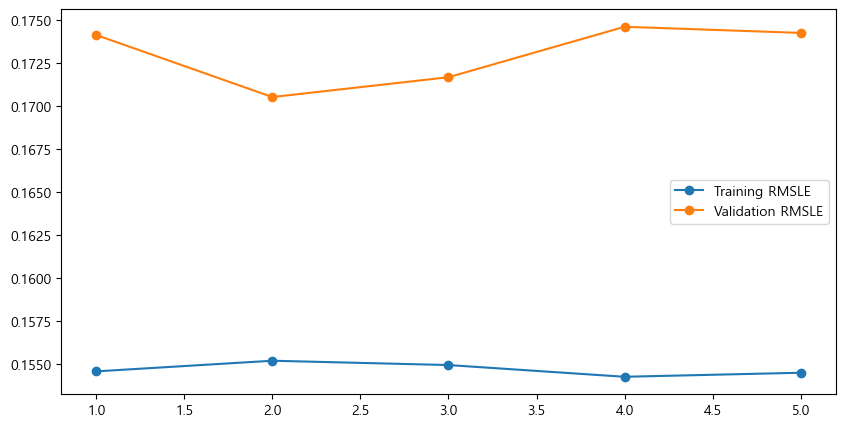

In [190]:
plt.figure(figsize=(10, 5))
plt.plot([1,2,3,4,5], cat_t_score, marker='o', label='Training RMSLE')
plt.plot([1,2,3,4,5], cat_v_score, marker='o', label='Validation RMSLE')
plt.legend()
plt.show()

## Ridge

In [191]:
start_time = time.time()
rid = Ridge(random_state=42).fit(x_train,y_train)
rid_base_pred = rid.predict(x_test)
print('Ridge RMSLE: {0:.4f}'.format(rmsle(y_test,rid_base_pred)))
evaluate_regr(y_test,rid_base_pred)
alphas = np.logspace(-4, 0, 200)
params = {
    'alpha':alphas,
}
rid_grid_cv = GridSearchCV(rid,param_grid = params, cv=3,n_jobs=-1,scoring=rmsle_scorer).fit(x_train,y_train)

print('최적 하이퍼 파라미터:\n', rid_grid_cv.best_params_)
rid_praram = rid_grid_cv.best_params_
rid_pred = rid_grid_cv.best_estimator_.predict(x_test)
print('rf RMSLE: {0:.4f}'.format(rmsle(y_test,rid_pred)))
print('수행속도 : {0:.1f}초'.format(time.time()-start_time))

Ridge RMSLE: 0.1719
MAE: 0.355, RMSE: 0.445, RMSLE: 0.172
최적 하이퍼 파라미터:
 {'alpha': 0.0001}
rf RMSLE: 0.1719
수행속도 : 1.8초


In [192]:
ridge = Ridge(random_state = 42) # **rid_grid_cv.best_params_,

kf = KFold(n_splits=5, shuffle=True)

# 각 fold의 모델로부터의 예측을 저장할 리스트와 MAE 점수 리스트
ensemble_predictions = []
rid_t_score = []
rid_v_score = []
for train_idx, val_idx in tqdm(kf.split(X_standard,y), total=5, desc="Processing folds"):
    X_t, X_val = X_standard[train_idx], X_standard[val_idx]
    y_t, y_val = y[train_idx], y[val_idx]
    
    # 두 모델 모두 학습
    ridge.fit(X_t, y_t)
    
    # 각 모델로부터 Validation set에 대한 예측을 평균내어 앙상블 예측 생성
    val_pred = ridge.predict(X_val)
    t_pred = ridge.predict(X_t)
    # Validation set에 대한 대회 평가 산식 계산 후 저장
    rid_v_score.append(rmsle(y_val, val_pred))
    rid_t_score.append(rmsle(y_t, t_pred))
    
    # test 데이터셋에 대한 예측 수행 후 저장
    ridge_pred = ridge.predict(test_standard)
    ridge_pred = np.where(catk_pred < 0, 0, ridge_pred)
    
    ensemble_predictions.append(np.expm1(ridge_pred))

# K-fold 모든 예측의 평균을 계산하여 fold별 모델들의 앙상블 예측 생성
ridge_final_predictions = np.mean(ensemble_predictions, axis=0)

# 각 fold에서의 Validation Metric Score와 전체 평균 Validation Metric Score출력
print("Validation : RMSLE scores for each fold:", rid_v_score)
print("Validation : RMSLE:", np.mean(rid_v_score))

Processing folds: 100%|██████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 72.98it/s]

Validation : RMSLE scores for each fold: [0.17041302875230435, 0.176235605064436, 0.1713447140410436, 0.17376239250763317, 0.17246381201085265]
Validation : RMSLE: 0.17284391047525394


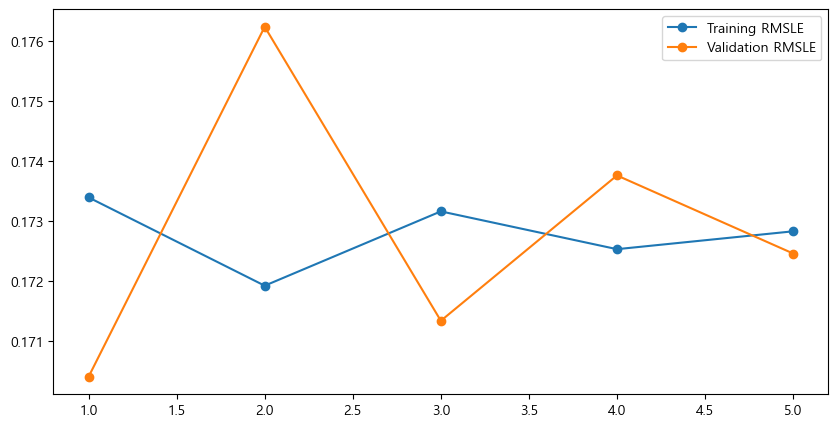

In [193]:
plt.figure(figsize=(10, 5))
plt.plot([1,2,3,4,5], rid_t_score, marker='o', label='Training RMSLE')
plt.plot([1,2,3,4,5], rid_v_score, marker='o', label='Validation RMSLE')
plt.legend()
plt.show()

## Lasso

In [194]:
start_time = time.time()
lasso = Lasso(random_state=42).fit(x_train,y_train)
lasso_base_pred = lasso.predict(x_test)
print('Lasso RMSLE: {0:.4f}'.format(rmsle(y_test,lasso_base_pred)))
evaluate_regr(y_test,lasso_base_pred)
alphas = np.logspace(-4, 0, 200)
params = {
    'alpha':alphas,
}
lasso_grid_cv = GridSearchCV(lasso,param_grid = params, cv=3,n_jobs=-1,scoring=rmsle_scorer).fit(x_train,y_train)

print('최적 하이퍼 파라미터:\n', lasso_grid_cv.best_params_)
lasso_praram = lasso_grid_cv.best_params_
lasso_pred = lasso_grid_cv.best_estimator_.predict(x_test)
print('rf RMSLE: {0:.4f}'.format(rmsle(y_test,lasso_pred)))
print('수행속도 : {0:.1f}초'.format(time.time()-start_time))

Lasso RMSLE: 0.1725
MAE: 0.358, RMSE: 0.447, RMSLE: 0.172
최적 하이퍼 파라미터:
 {'alpha': 0.047137531341167244}
rf RMSLE: 0.1725
수행속도 : 2.5초


In [195]:
lasso = Lasso(random_state = 42) # **lasso_grid_cv.best_params_,

kf = KFold(n_splits=5, shuffle=True)

# 각 fold의 모델로부터의 예측을 저장할 리스트와 MAE 점수 리스트
ensemble_predictions = []
la_t_score = []
la_v_score = []
for train_idx, val_idx in tqdm(kf.split(X_standard,y), total=5, desc="Processing folds"):
    X_t, X_val = X_standard[train_idx], X_standard[val_idx]
    y_t, y_val = y[train_idx], y[val_idx]
    
    # 두 모델 모두 학습
    lasso.fit(X_t, y_t)
    
    # 각 모델로부터 Validation set에 대한 예측을 평균내어 앙상블 예측 생성
    val_pred = lasso.predict(X_val)
    t_pred = lasso.predict(X_t)
    # Validation set에 대한 대회 평가 산식 계산 후 저장
    la_v_score.append(rmsle(y_val, val_pred))
    la_t_score.append(rmsle(y_t, t_pred))
    
    # test 데이터셋에 대한 예측 수행 후 저장
    lasso_pred = lasso.predict(test_standard)
    lasso_pred = np.where(lasso_pred < 0, 0, lasso_pred)
    
    ensemble_predictions.append(np.expm1(lasso_pred))

# K-fold 모든 예측의 평균을 계산하여 fold별 모델들의 앙상블 예측 생성
lasso_final_predictions = np.mean(ensemble_predictions, axis=0)

# 각 fold에서의 Validation Metric Score와 전체 평균 Validation Metric Score출력
print("Validation : RMSLE scores for each fold:", la_v_score)
print("Validation : RMSLE:", np.mean(la_v_score))

Processing folds: 100%|██████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 47.92it/s]

Validation : RMSLE scores for each fold: [0.17123914275329072, 0.17425064764555395, 0.17722581604976392, 0.1729241474840421, 0.17373587201568777]
Validation : RMSLE: 0.1738751251896677


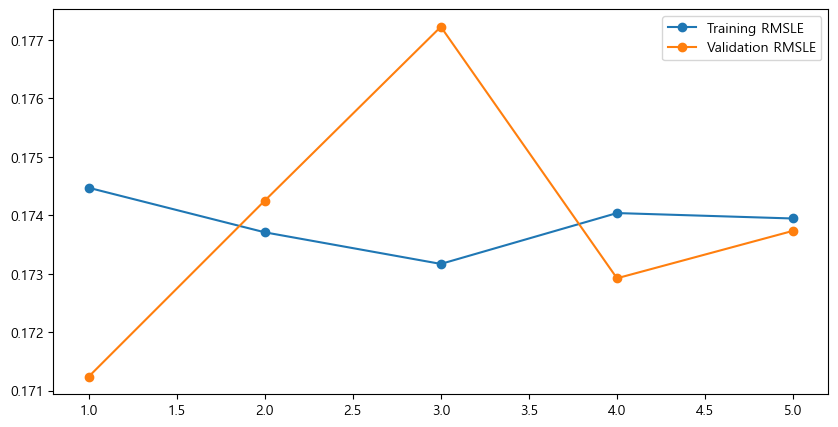

In [196]:
plt.figure(figsize=(10, 5))
plt.plot([1,2,3,4,5], la_t_score, marker='o', label='Training RMSLE')
plt.plot([1,2,3,4,5], la_v_score, marker='o', label='Validation RMSLE')
plt.legend()
plt.show()

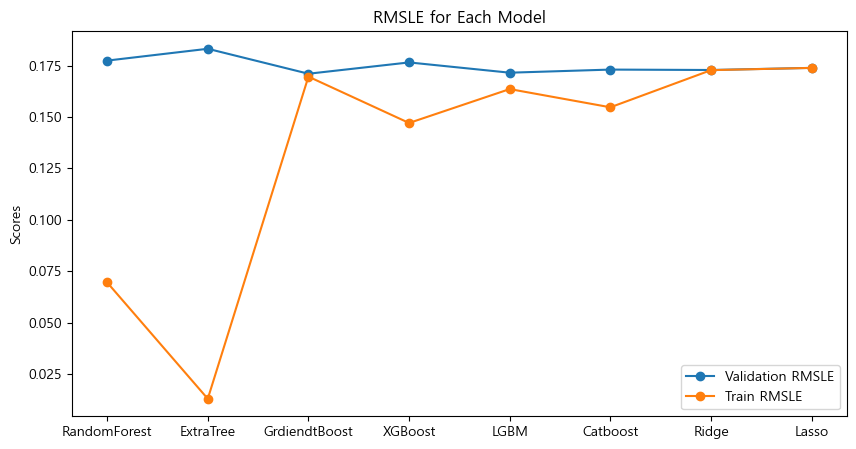

In [197]:
names = ['RandomForest','ExtraTree','GrdiendtBoost','XGBoost','LGBM','Catboost','Ridge','Lasso']
rmsle_val = [np.mean(rf_v_score),np.mean(ex_v_score),np.mean(gbk_v_score),np.mean(xgb_v_score)
             ,np.mean(lgb_v_score),np.mean(cat_v_score),np.mean(rid_v_score),np.mean(la_v_score)]
rmsle_tr = [np.mean(rf_t_score),np.mean(ex_t_score),np.mean(gbk_t_score),
            np.mean(xgb_t_score),np.mean(lgb_t_score),np.mean(cat_t_score),np.mean(rid_t_score),np.mean(la_t_score)]

plt.figure(figsize=(10, 5))
plt.plot(names,rmsle_val, marker='o', label='Validation RMSLE')
plt.plot(names, rmsle_tr, marker='o', label='Train RMSLE')

plt.ylabel('Scores')
plt.title('RMSLE for Each Model')
plt.legend()

plt.show()


[0]	validation_0-rmsle:0.38445	validation_1-rmsle:0.38537
[1]	validation_0-rmsle:0.28026	validation_1-rmsle:0.28161
[2]	validation_0-rmsle:0.22335	validation_1-rmsle:0.22531
[3]	validation_0-rmsle:0.19365	validation_1-rmsle:0.19617
[4]	validation_0-rmsle:0.17892	validation_1-rmsle:0.18205
[5]	validation_0-rmsle:0.17204	validation_1-rmsle:0.17557
[6]	validation_0-rmsle:0.16866	validation_1-rmsle:0.17295
[7]	validation_0-rmsle:0.16698	validation_1-rmsle:0.17199
[8]	validation_0-rmsle:0.16631	validation_1-rmsle:0.17165
[9]	validation_0-rmsle:0.16585	validation_1-rmsle:0.17165
[10]	validation_0-rmsle:0.16547	validation_1-rmsle:0.17179
[11]	validation_0-rmsle:0.16536	validation_1-rmsle:0.17198
[12]	validation_0-rmsle:0.16504	validation_1-rmsle:0.17210
[13]	validation_0-rmsle:0.16459	validation_1-rmsle:0.17229
[14]	validation_0-rmsle:0.16438	validation_1-rmsle:0.17233
[15]	validation_0-rmsle:0.16403	validation_1-rmsle:0.17248
[16]	validation_0-rmsle:0.16367	validation_1-rmsle:0.17262
[17]	va

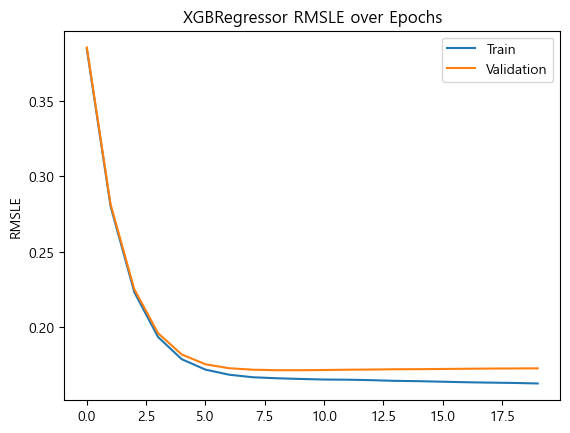

Xgboost Best Epoch:  9


In [51]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.25, random_state = 42)
reg_xgb = XGBRegressor()
eval_set = [(x_train, y_train), (x_val, y_val)]
reg_xgb.fit(x_train, y_train, eval_metric="rmsle", eval_set=eval_set,
            early_stopping_rounds=10, verbose=True)
# Accessing the RMSE values stored during training
results = reg_xgb.evals_result()
epochs = len(results['validation_0']['rmsle'])
x_axis = range(0, epochs)

# Plotting
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['rmsle'], label='Train')
ax.plot(x_axis, results['validation_1']['rmsle'], label='Validation')
ax.legend()
plt.ylabel('RMSLE')
plt.title('XGBRegressor RMSLE over Epochs')
plt.show()

best_epoch = reg_xgb.best_iteration
print("Xgboost Best Epoch: ", best_epoch)

In [59]:
xgb_score = reg_xgb.predict(test_standard, iteration_range=(0, best_epoch + 1))
np.expm1(xgb_score)

array([3.5940766, 3.038095 , 4.839592 , ..., 4.326035 , 4.99602  ,
       4.082655 ], dtype=float32)

# 🚩 soft Voting

In [123]:
start_time = time.time()
ET = ex_grid_cv.best_estimator_
LGBM = lgb_grid.best_estimator_
XGB = xgb_grid.best_estimator_
RF =rf_grid_cv.best_estimator_
GB = grid_cv.best_estimator_
C = catcv.best_estimator_
RD =  rid_grid_cv.best_estimator_
LS = lasso_grid_cv.best_estimator_

#VC = VotingRegressor(estimators=[('ExtraTree',ET),('RandomForest',RF),('XGBoost',XGB),('LGBM',LGBM),('GradientBoost',GB)]).fit(x_train,y_train)
# VC = VotingRegressor(estimators=[('ExtraTree',ET),('RandomForest',RF),('LGBM',LGBM),('CATboost',C)]).fit(x_train,y_train)
# VC = VotingRegressor(estimators=[('ExtraTree',ET),('RandomForest',RF),('LGBM',LGBM)]).fit(x_train,y_train)
#VC = VotingRegressor(estimators=[('ExtraTree',ET),('LGBM',LGBM)]).fit(x_train,y_train)
#VC = VotingRegressor(estimators=[('ExtraTree',ET),('RandomForest',RF)]).fit(x_train,y_train)
#VC = VotingRegressor(estimators=[('ExtraTree',ET),('RandomForest',RF),('CATboost',C)]).fit(x_train,y_train)
# VC = VotingRegressor(estimators=[('ExtraTree',ET),('RandomForest',RF),('Ridge',RD),('Lasso',LS)]).fit(x_train,y_train)
# VC = VotingRegressor(estimators=[('LGBM',LGBM),('GradientBoost',GB),('CATboost',C)]).fit(x_train,y_train)
VC = VotingRegressor(estimators=[('ExtraTree',ET),('RandomForest',RF),('GradientBoost',GB)]).fit(x_train,y_train)
vc_pred = VC.predict(x_test)
print('Voting RMSLE: {0:.4f}'.format(rmsle(y_test,vc_pred)))
evaluate_regr(y_test,vc_pred)
vc_time = time.time()-start_time
print('수행속도 : {0:.1f}초'.format(vc_time))

Voting RMSLE: 0.1754
MAE: 0.360, RMSE: 0.457, RMSLE: 0.175
수행속도 : 45.8초


In [79]:
total_result = pd.DataFrame({'Model':['ExtraTree','GradientBoosting','RandomForest','XGBRegressor','LGBMRegressor','Catboost','Ridge','Lasso','Voting'],
              'Basic_RMSLE':[rmsle(y_test,ex_base_pred),rmsle(y_test,gb_base_pred),rmsle(y_test,rf_base_pred),rmsle(y_test,xgb_base_pred),rmsle(y_test,lgb_base_pred),rmsle(y_test,cat_base_pred),
                             rmsle(y_test,rid_base_pred),rmsle(y_test,lasso_base_pred),'-']
             ,'RMSLE':[np.mean(rf_v_score),np.mean(ex_v_score),np.mean(gbk_v_score),np.mean(xgb_v_score)
             ,np.mean(lgb_v_score),np.mean(cat_v_score),np.mean(rid_v_score),np.mean(la_v_score),rmsle(y_test,vc_pred)],
             'Best HyperParameter':[ex_praram,GBM_praram,rf_praram,xgb_praram,lbg_praram,catcv.best_params_,rid_praram,lasso_praram,'-']})
total_result

,Model,Basic_RMSLE,RMSLE,Best HyperParameter
0,ExtraTree,0.182863,0.172612,"{'bootstrap': True, 'max_depth': 10, 'max_feat..."
1,GradientBoosting,0.171407,0.172163,"{'learning_rate': 0.1, 'max_depth': 10, 'n_est..."
2,RandomForest,0.177175,0.192985,"{'max_depth': 15, 'min_samples_leaf': 5, 'min_..."
3,XGBRegressor,0.175901,0.235938,"{'eval_metric': 'rmsle', 'learning_rate': 0.01..."
4,LGBMRegressor,0.171853,0.171691,"{'bagging_fraction': 0.1, 'eval_metric': 'rmsl..."
5,Catboost,0.173024,0.171218,"{'depth': 4, 'l2_leaf_reg': 7, 'learning_rate'..."
6,Ridge,0.172927,0.172982,{'alpha': 0.0001}
7,Lasso,0.173948,0.173866,{'alpha': 0.04102658105827194}
8,Voting,-,0.175354,-


In [80]:
total_result.sort_values(by=['RMSLE','Basic_RMSLE'])

,Model,Basic_RMSLE,RMSLE,Best HyperParameter
5,Catboost,0.173024,0.171218,"{'depth': 4, 'l2_leaf_reg': 7, 'learning_rate'..."
4,LGBMRegressor,0.171853,0.171691,"{'bagging_fraction': 0.1, 'eval_metric': 'rmsl..."
1,GradientBoosting,0.171407,0.172163,"{'learning_rate': 0.1, 'max_depth': 10, 'n_est..."
0,ExtraTree,0.182863,0.172612,"{'bootstrap': True, 'max_depth': 10, 'max_feat..."
6,Ridge,0.172927,0.172982,{'alpha': 0.0001}
7,Lasso,0.173948,0.173866,{'alpha': 0.04102658105827194}
8,Voting,-,0.175354,-
2,RandomForest,0.177175,0.192985,"{'max_depth': 15, 'min_samples_leaf': 5, 'min_..."
3,XGBRegressor,0.175901,0.235938,"{'eval_metric': 'rmsle', 'learning_rate': 0.01..."


In [54]:
cat_res = np.expm1(catcv.best_estimator_.predict(test_standard))
cat_res

array([3.91133966, 3.62803689, 5.24790923, ..., 4.50883249, 4.76514354,
       4.62507162])

In [55]:
catk_final_predictions

array([3.70261767, 3.49967605, 5.32899844, ..., 4.5159076 , 4.53594907,
       4.69614257])

In [56]:
np.expm1(VC.predict(test_standard))

array([4.03163308, 3.80047227, 4.42553415, ..., 4.25868384, 4.53191302,
       4.465275  ])

In [78]:
np.expm1(VC.predict(test_standard))

array([3.58940788, 3.66867173, 3.98524208, ..., 4.46013937, 5.94415312,
       5.77864036])

In [ ]:
#etrflgb
exk_final_predictions,rf_final_predictions,gbk_final_predictions

In [126]:
fins = []
for a,b in zip(lasso_final_predictions,ridge_final_predictions):
    fins.append((a+b)/2)
fins

[4.096897604832881,
 3.9913934812213165,
 4.33184164860414,
 4.212242645088191,
 4.365558610780415,
 4.202642728623617,
 4.279022107154024,
 4.004749524514171,
 4.167009794298252,
 4.308500818012885,
 4.218848202487981,
 3.939387868030341,
 4.1893460129096,
 3.9653781184463965,
 3.934254790489916,
 4.282390266035457,
 4.276822440741274,
 4.211564097355925,
 4.187632813689522,
 4.229713048561035,
 4.328824805785728,
 3.869044364958469,
 4.306224451680976,
 4.270079604162727,
 4.224120160733377,
 4.334289272756409,
 4.182864001069072,
 4.1380868207023,
 3.9336699101490327,
 4.288007381143183,
 4.299345381278286,
 4.177353166713422,
 4.264283899517793,
 4.435028318178023,
 4.165526037452407,
 3.9260341460583863,
 4.487062103128473,
 4.2637026117167505,
 4.174841694068053,
 4.279063118931317,
 3.9208081014630287,
 3.971892316054713,
 4.498538424361561,
 4.307321792513677,
 4.063582131776709,
 4.047076737319511,
 4.282322408027858,
 3.9666879450647707,
 4.246427368802711,
 4.179060655921644

In [ ]:
lgb_b_pred = np.expm1(lgb_grid.best_estimator_.predict(test_standard))
lgb_b_pred

In [ ]:
ex_b_pred = np.expm1(ex_grid_cv.best_estimator_.predict(test_standard))
ex_b_pred

In [ ]:
lgb_b_pred = np.expm1(grid_cv.best_estimator_.predict(test_standard))
lgb_b_pred

In [143]:
gbk_final_predictions

array([4.67844854, 3.80896951, 4.09407012, ..., 3.07287506, 7.68786748,
       7.20917733])

In [147]:
submission = pd.read_csv('C:/Users/User/Desktop/대구교통사고예측/sample_submission.csv')
submission['ECLO'] = catk_final_predictions 
submission.to_csv('C:/Users/User/Desktop/대구교통사고예측/catk_final_predictions .csv',index=False)
submission

,ID,ECLO
0,ACCIDENT_39609,3.543958
1,ACCIDENT_39610,3.632275
2,ACCIDENT_39611,5.498371
3,ACCIDENT_39612,4.665983
4,ACCIDENT_39613,4.099441
...,...,...
10958,ACCIDENT_50567,3.874147
10959,ACCIDENT_50568,3.864571
10960,ACCIDENT_50569,4.464840
10961,ACCIDENT_50570,5.568701
